In [3]:
import pandas as pd
import numpy as np
import json
import geopandas as gp
import h3
import h3pandas
from placekey.api import PlacekeyAPI
from keplergl import KeplerGl
import pprint
# import concurrent.futures
from unsync import unsync

import gzip 
from shapely.geometry import shape
from collections import Counter

# import modin.pandas as mpd # Mutiple workers keep failing!
from zipfile import ZipFile as ZF

from glob import glob
# https://stackoverflow.com/a/65001152/12572612: from multiprocessing import Pool
from multiprocess import Pool
# import vaex 

# 50 states + DC + 6 territories (PR, VI, AS, GU, MP, UM)
SF57 = {'01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY', '60': 'AS', '66': 'GU', '69': 'MP', '72': 'PR', '74': 'UM', '78': 'VI'}
SF57R = {value : key for (key, value) in SF57.items()}
# 50 states + DC + PR + VI
SF53 = {'01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR', '78': 'VI'}
SF53R = {value : key for (key, value) in SF53.items()}
# 50 states + DC + PR
SF52 = {'01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'}
SF52R = {value : key for (key, value) in SF52.items()}
# 50 states + DC
SF51 = {'01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY'}
SF51R = {value : key for (key, value) in SF51.items()}


def gen_h3_hex_vectors(lat, lon, res):
    return h3.geo_to_h3(lat, lon, res)
# vectorize is 10x faster than apply!
gen_h3_hex = np.vectorize(gen_h3_hex_vectors)

# FYI: h3.h3_indexes_are_neighbors("X1", "X1") = False (i.e. a hex cell is not neighbor with itself)
# aside: h3.k_ring("8843a13687fffff", 1) # find all neighbors in ring_size=1
def h3_nei_conditions(hex1, hex2):
    return h3.h3_indexes_are_neighbors(hex1, hex2) # bool
h3_nei_vector = np.vectorize(h3_nei_conditions)

# pd.set_option('display.max_columns', None) # number of the maximum columns shown
# pd.set_option('display.max_colwidth', 100) # the maximum width of each single field.

all_possible_bad_values = ["", " ", "null", "Null", "None", "NONE", "none", "nan", "Nan"] 


attom_header = (['[ATTOM ID]', 'AreaBuilding', 'AreaBuildingDefinitionCode', 'AreaLotSF', 'AssessorLastSaleAmount', 'AssessorLastSaleDate', 'AssessorPriorSaleAmount', 'AssessorPriorSaleDate', 'BedroomsCount', 'BuildingsCount', 'CensusBlock', 'CompanyFlag', 'ContactOwnerMailAddressFull', 'ContactOwnerMailAddressInfoFormat', 'DeedOwner1NameFull', 'Fireplace', 'FireplaceCount', 'GeoQuality', 'LegalDescription', 'OwnerTypeDescription1', 'ParcelNumberRaw', 'ParkingGarage', 'ParkingGarageArea', 'ParkingSpaceCount', 'PartyOwner1NameFull', 'PartyOwner2NameFull', 'PartyOwner3NameFull', 'PreviousAssessedValue', 'PropertyAddressCity', 'PropertyAddressFull', 'PropertyAddressHouseNumber', 'PropertyAddressState', 'PropertyAddressStreetDirection', 'PropertyAddressStreetName', 'PropertyAddressStreetPostDirection', 'PropertyAddressStreetSuffix', 'PropertyAddressUnitPrefix', 'PropertyAddressUnitValue', 'PropertyAddressZIP', 'PropertyAddressZIP4', 'PropertyLatitude', 'PropertyLongitude', 'PropertyUseGroup', 'PropertyUseStandardized', 'RoofConstruction', 'RoomsCount', 'RoomsFamilyCode', 'RoomsGameFlag', 'SitusCounty', 'SitusStateCode', 'StatusOwnerOccupiedFlag', 'StoriesCount', 'TaxAssessedValueImprovements', 'TaxAssessedValueTotal', 'TaxMarketValueImprovements', 'TaxMarketValueTotal', 'TaxMarketValueYear', 'TaxYearAssessed', 'UnitsCount', 'YearBuilt']
 + ['zorder', 'rorder']) # added 2 columns
len(attom_header)

attom_cols = ['[ATTOM ID]',     
    'LegalDescription', 'OwnerTypeDescription1', 'ParcelNumberRaw', 
    'PartyOwner1NameFull', 'PartyOwner2NameFull', 
    'PropertyAddressCity', 
    'PropertyAddressFull', 
    'PropertyAddressHouseNumber', 'PropertyAddressStreetDirection', 'PropertyAddressStreetName', 
    'PropertyAddressStreetPostDirection', 'PropertyAddressStreetSuffix', 'PropertyAddressUnitPrefix', 'PropertyAddressUnitValue', 
    'PropertyAddressZIP', 
    'PropertyLatitude', 'PropertyLongitude',]

all_props = ['geoid', 'sourceagent', 'parcelnumb', 'usecode', 'usedesc', 'zoning', 'zoning_description', 'struct', 'multistruct', 'structno', 'yearbuilt', 'numstories', 'numunits', 'structstyle', 'parvaltype', 'improvval', 'landval', 'parval', 'agval', 'saleprice', 'saledate', 'taxamt', 'owntype', 'owner', 'ownfrst', 'ownlast', 'owner2', 'owner3', 'owner4', 'subsurfown', 'subowntype', 'mailadd', 'mail_address2', 'careof', 'mail_addno', 'mail_addpref', 'mail_addstr', 'mail_addsttyp', 'mail_addstsuf', 'mail_unit', 'mail_city', 'mail_state2', 'mail_zip', 'mail_urbanization', 'mail_country', 'address', 'address2', 'original_address', 'saddno', 'saddpref', 'saddstr', 'saddsttyp', 'saddstsuf', 'sunit', 'scity', 'city', 'county', 'state2', 'szip', 'urbanization', 'location_name', 'address_source', 'legaldesc', 'plat', 'book', 'page', 'block', 'lot', 'neighborhood', 'subdivision', 'qoz', 'qoz_tract', 'census_block', 'census_blockgroup', 'census_tract', 'census_school_district', 'sourceref', 'sourcedate', 'sourceurl', 'recrdareatx', 'recrdareano', 'gisacre', 'll_gisacre', 'sqft', 'll_gissqft', 'll_bldg_footprint_sqft', 'll_bldg_count', 'reviseddate', 'path', 'll_stable_id', 'll_uuid', 'll_updated_at', 'dpv_status', 'dpv_codes', 'dpv_notes', 'dpv_type', 'cass_errorno', 'rdi', 'usps_vacancy', 'usps_vacancy_date', 'cdl_raw', 'cdl_date', 'cdl_majority_category', 'cdl_majority_percent', 'padus_public_access', 'lbcs_activity', 'lbcs_activity_desc', 'lbcs_function', 'lbcs_function_desc', 'lbcs_structure', 'lbcs_structure_desc', 'lbcs_site', 'lbcs_site_desc', 'lbcs_ownership', 'lbcs_ownership_desc', 'lat', 'lon', 'taxyear', 'stacked_flag', 'll_last_refresh', 'll_address_count', 'homestead_exemption', 'alt_parcelnumb1', 'alt_parcelnumb2', 'alt_parcelnumb3', 'parcelnumb_no_formatting', 'plss_township', 'plss_section', 'plss_range' ]
regrid_header = all_props + ['geom']
# NOTE: geom = WTK string/object type; geometry = geopandas geometry type
CRS_REGRID_PARCELS = "EPSG:4326"

regrid_cols = ['ll_uuid', 
    'address', 
   'address2', # i.e. alternative address for same parcel
   # 'original_address', # confirmed: all useless when (~address & original_address)
               'legaldesc', 'parcelnumb', 
    'saddno', 'saddpref', 'saddstr', 'saddsttyp', 'saddstsuf', 'sunit' ,
    'scity', 'szip', 'lat', 'lon', 
    'owner', 'owner2', ]

def owner_compare(df_compare, left, right):
    # only keep alphanumeric values ; note the additions of symbols
    keepchars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" + ",& "
    del_chars = ''.join(c for c in map(chr, range(1114111)) if not c in set(keepchars))
    # convert uppercases to lowercases
    keepchars_table = str.maketrans(keepchars, keepchars.lower(), del_chars)

    df_compare['owners'] = df_compare[left].str.translate(keepchars_table).str.split(',|&| ')
    df_compare['Owners'] = df_compare[right].str.translate(keepchars_table).str.split(',|&| ')

    def owners_combine(owners, Owners):
        if owners is not np.nan and Owners is not np.nan:
            seta = {own for own in owners if len(own) > 1}
            setb = {own for own in Owners if len(own) > 1}
            return True if seta.intersection(setb) else False
        return True
    owners_combine_vectorize = np.vectorize(owners_combine)
    return owners_combine_vectorize(df_compare['owners'], df_compare['Owners'])


# pd.options.display.float_format = '{:_}'.format
# # Format thousands delimiter 
# df.style.format(thousands='_')

attom_pk_maps = {
    'aid' : 'query_id', # unique row id
    'Lat' : 'latitude', 
    'Lon' : 'longitude', 
    'Address1' : 'street_address', # NOTE: using address1
    'ACity' : 'city',
    'AZip' : 'postal_code',
}

regrid_pk_maps = {
    'rid' : 'query_id', # unique row id
    'lat' : 'latitude', 
    'lon' : 'longitude', 
    'address1' : 'street_address', # NOTE: using address1
    'scity' : 'city',
    'szip' : 'postal_code', # e.g. 48103, 48104-3423
}

pk_api1 = PlacekeyAPI("NDd0VsiPKznvm89NLNj9DHrtU3GVzZ1h" )
pk_api2 = PlacekeyAPI("50L6WAI5cSUz1gJ3qzr2AwQxANKP3Ty1" )

#  https://github.com/alex-sherman/unsync#multi-threading-an-io-bound-function
# Iterative API calls= slow! Use unsync that simplifies ThreadPoolExecutor's async tasks
@unsync
def pk_call(df, maps, orig_id, pk_api):
    def gen_placekey_df(df, maps):
        keep_cols = list(maps.values())
        # only need placekey cols
        # drop columns with names similar to Placekey required columns
        df = df.drop(columns=keep_cols, 
                     errors='ignore').rename(columns=maps)[keep_cols]

        # df['location_name'] = 'attom_null'

        # # Done; DONT NEED: coerce types to conform to Placekey API
        # df[['latitude', 'longitude']] = df[['latitude', 'longitude']].astype(float)
        # df[['query_id', 'street_address', 'city']] = df[['query_id', 'street_address', 'city']].astype(str)

        # zipcode = 00000 means null; ATTOM zipcode could be a float, or None, ""
        # so, need a placeholder value to convert to int, zfill, back to np.nan
        NAN_ZIPS = "00000"
        df['postal_code'] = df['postal_code'].fillna(NAN_ZIPS).astype(int).astype(str).str.zfill(5).replace(NAN_ZIPS, np.nan)
        # print("Generated pk df ", df.shape)
        
        # OPTIONAL CLEANING
        possible_bad_values = ["", " ", "null", "Null", "None", "nan", "Nan"]  
        for bad_value in possible_bad_values:
            df = df.replace(bad_value, np.nan)
        # replace NoneType with np.nan    
        df.fillna(np.nan, inplace=True)
        return df    
    
    # Placekey API lookup function
    
    def pk_lookup(df, pk_api):
        # add missing hard-coded columns (str type)
        df['iso_country_code'] = 'US' 
        # sf_code has GLOBAL SCOPE
        df['region'] = sf_code.upper()    
        df = json.loads(df.to_json(orient='records'))
        # Rate limit: 100 bulk req per min x 100 addrs per bulk req
        # i.e. 10,000 addr per min 
        responses =  pk_api.lookup_placekeys(df, 
                                        strict_address_match=False,
                                        strict_name_match=False, 
                                        # verbose=True,
                                       )
        # Clean the responses
        # print("number of requests sent: ", len(df))
        # print("total queries returned:", len(responses))
        # filter out invalid responses
        responses_cleaned = [resp for resp in responses if 'query_id' in resp]
        # print("total successful responses:", len(responses_cleaned))
        return pd.read_json(json.dumps(responses_cleaned), dtype={'query_id':str})
    
    
    # TODO opt: groupby address1+hex7: avoid duplicate Placekey API request!
    # assumption: there should be no duplicate address1 within same ahex7 (within 5km2)
    # will not filter: same addr & adjacent ahex7 - placekey API will verify!
    # FAILED: concat address with zip, eliminate repeated address (https://www.quora.com/Do-any-two-locations-with-the-same-street-address-also-have-the-same-ZIP-code)
    # also, groupby fails when zip is null!
    df_pk = gen_placekey_df(df, maps)
    
    # API REQUEST
    pk_res =  pk_lookup(df_pk.copy(), pk_api) # # (148_487, 6) around 15min
    # Show API responses errors
    if "error" in set(pk_res):
        print(orig_id, "# responses: ", pk_res.shape, "; responses errors: ")
        print(pk_res.error.value_counts())
    # split into 2 components -- only interest in results with pkwhat
    # this also filters rows with error i.e. no placekey
    pk_res[['pkwhat', 'pkwhere']] = pk_res.placekey.str.split(
        "@", expand=True).replace("", np.nan)
   
    # Save API responses!!
    pk_res.reset_index(drop=True).to_feather(f'placekeyed/{orig_id}_{sf_code}.ftr')
    
    # keep only results whith pkwhat components
    pk_res = pk_res[pk_res.pkwhat.notna()]
    # Merge with original df; keep only rows with placekey results
    df = pd.merge(df, pk_res, left_on = orig_id, 
      right_on="query_id", how='inner').drop(columns= ['query_id', 'error'])
    return df


/home/nhat/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
def regrid_landuse_classifier(acti, func, struc, site):
    # REGRID LAND USE CLASSIFICATION
    # Higher to lower priority
    if 1 in (acti, func, struc):
        return 'resi'
    if 2 in (acti, func, struc) or func in set('357') or acti in set('357'):
        return 'biz'
    if 8 in (acti, struc) or func == 9: 
        return 'farm'
    # 4000 - Social, institutional, or infrastructure-related activities
    # 6000 - Mass assembly of people
    # 4000 - Transportation, communication, information, and utilities
    # 6000 - Education, public admin., health care, and other inst.
    # 3000 - Public assembly structures
    # .. 6000 - Utility and other nonbuilding structures
    if 4 in (acti, func) or 6 in (acti, func) or struc in set('34567'):
        return 'CAI'
    if site != 6: # no developed site on land
        return 'vacland'    
    return 'rem' # ALL OTHER LANDUSE GROUPS   


def rad_fields_vec(rid, aid, address1, addressSub, Address1, AddressSub, lat, lon, Lat, Lon, owner, owner2, Owner, Owner2):
    pId = rId = pAddress1 = pAddressSub = pOwner = pLat = pLon = np.nan
    
    rlist = [rid, address1, addressSub, lat, lon, owner, owner2]
    for r, addr1, addrSub, la, lo, own, own2 in zip(*rlist):
        pId = rId = r
        if addr1 is not None and addr1 == addr1: # not None, not na
            pId = rId = r
            pAddress1, pAddressSub = addr1, addrSub
        if la is not None and lo is not None and la == la and lo == lo:
            pLat, pLon = la, lo
        if own is not None and own == own:
            pOwner = own
        elif own2 is not None and own2 == own2:
            pOwner = own2
        if np.nan not in (pId, rId, pAddress1, pAddressSub, pOwner, pLat, 
           pLon):
            return "\t".join([str(k) for k in [pId, rId, pAddress1, pAddressSub, pOwner, pLat, pLon]])

    alist = [aid, Address1, AddressSub, Lat, Lon, Owner, Owner2]
    for a, addr1, addrSub, la, lo, own, own2 in zip(*alist):
        if pId != pId: # if have seen no regrid parcel 
            pId = a
        if pAddress1 != pAddress1 and addr1 is not None and addr1 == addr1: # not na
            pId = a # rId would still be Nan, or equal to a previous rid
            pAddress1, pAddressSub = addr1, addrSub
        if pLat != pLat and pLon != pLon and la is not None and lo is not None and la == la and lo == lo:
            pLat, pLon = la, lo
        if pOwner != pOwner and own is not None and own == own:
            pOwner = own
        elif pOwner != pOwner and own2 is not None and own2 == own2:
            pOwner = own2
        if np.nan not in (pId, rId, pAddress1, pAddressSub, pOwner, pLat, 
           pLon):
            return "\t".join([str(k) for k in [pId, rId, pAddress1, pAddressSub, pOwner, pLat, pLon]])
        
    return "\t".join([str(k) for k in [pId, rId, pAddress1, pAddressSub, pOwner, pLat, pLon]])


def rad_landuse_classifier_single(alanduse, rlanduse):
    # RAD LAND USE CLASSIFICATION: reconciling ATTOM <> REGRID
    # Higher to lower prioritization
    if alanduse in ('CAI', 'biz', 'resi'): # also in order of priority
        return alanduse
    if rlanduse in ('CAI', 'biz', 'resi'): # also in order of priority
        return rlanduse
    for weak in ('farm', 'vacland', 'rem'): # also in order of priority
        if weak in set((alanduse, rlanduse)):
            return weak

SORT_ORDER = {'CAI': 10, 'biz': 9, 'resi': 8, 'farm': 7, 'vacland': 6, 'rem': 5, np.nan: 4}
def rad_landuse_classifier_many(uses):
    # RAD LAND USE CLASSIFICATION: reconciling [many] ATTOM <> [many] REGRID
    c = Counter(uses).most_common()
    # note: negative signs! descending by counts, then descending by SORT_ORDER (for breaking tie)
    landuse_orders = sorted(c, key = lambda x: (-x[1], -SORT_ORDER[x[0]]))
    for value, count in landuse_orders:
        if value not in ('vacland', 'rem', np.nan):
            return value
    if 'vacland' in set([k[0] for k in landuse_orders]): 
        return 'vacland'
    return 'rem'


In [ ]:
government = ["Government", "Justice", "Library", "Department", "Administration","Dept of", "City of", "Dept of", 
              "Town of", "Commission", "National Foundation",  "Child Abuse", "Courthouse", "Department of ", 
              "Leadership", "Authority","Adoptions", "Prison","Veteran", "Chamber of", "Municipal","Child Support"]
religious = ["Church", "Baptist","Baptist Association","Christ","Family Harvest"]
community = ["Communications Workers Of America", "Veteran", "Community Center", "Community"]
education = ["High School", "Elementary School", "Education","College", 
                    "University", "Pre-School","Middle School", "School"]
outdoor = ["Garden", "Zoo", "Park", "Recreation", "Stadium", "Memorial", 
           "Outlook", "Overlook", "Pavilion", "Square", "Field", "Resort"]

stopcats = ['PERSONAL SERVICES',  'EATING - DRINKING', 'SHOPPING', 
       'AUTOMOTIVE SERVICES',  'BANKS - FINANCIAL', 'PET SERVICES']
keywords = {
    "health": ["Medical Center","Hospital","Clinic","Family Care", 
                 # "Rehab"
                ],
    "education": education, "government": government, "community": community, 
    "religious": religious, "outdoor": outdoor,
}

STOP_PARTS = ["LLC", "Llc", "inc", "Inc", "INC"]
stopwords = {
    "health":     STOP_PARTS + ["Hospitality", "Hospitalities", "Schools", "Animal", "Pet"],
    "education":  STOP_PARTS + ["Hospital"],
    "government": STOP_PARTS + ["Department Store"],
    "community":  STOP_PARTS,
    "religious":  STOP_PARTS,
    "outdoor":    STOP_PARTS,
}
caikeys = {
    "health": ["Medical Center","Hospital","Family Care"],
    "education": education, "government": government, "community": community, 
    "religious": religious, "outdoor": outdoor,
}

def getcai(dfinput, category):
    #STEP 1. use the name key word
    df = dfinput[dfinput["BUSNAME"].str.contains("|".join(keywords[category]))]
    #2.  remove the ones that contain the stop word
    df = df[~df["BUSNAME"].str.contains("|".join(stopwords[category]))]
    df = df[~df["CATEGORY"].isin(stopcats)]
    # 3. Find the CAI
    caidf = df[df["BUSNAME"].str.contains("|".join(caikeys[category]))]
    return caidf, df

## CONVERT CSV to FEATHER format (for both attom and regrid)
- run parallel csv2feather.py inside cmds.bash

## ATTOM


### download 16 raw files (monthly update) @ attom/attom-wget.bash


### Convert txt files inside ATTOM zips into small sf_x.ftr files

In [9]:
# CHUNK_SIZE = 150_000    

# def process_chunk(file_source, chunk_order, chunk_df):
#     chunk_df.set_index("SitusStateCode", inplace=True)
#     # only good keys
#     present_sf = chunk_df.index.intersection(SF57R.keys())
#     for sf in present_sf:
#         name = f"{sf}_F_{file_source}_C{CHUNK_SIZE}_{chunk_order}" # all upper cases
#         # print(file_source, chunk_order, chunk_df.shape, sf)
#         # use .loc[[sf]] to get a DataFrame every time (.loc[sf] sometimes returns a Series, which doesn't have .to_feather method)
#         chunk_df.loc[[sf]].reset_index(drop=True).to_feather(f'attom/data/attom-feather-temp/{name}.ftr')
        
# def process_zip(zpath): 
#     with ZF(zpath) as zfile_reader:
#         for file in zfile_reader.namelist():
#             if file.endswith('.txt'):
#                 # print(f"Parsing txt file {file} \n")
#                 with zfile_reader.open(file) as reader:
#                     chunks = pd.read_csv(reader, sep='\t', 
#                                           dtype=str, # coerce all columns as str (slower), else pd fails to infer mix type columns
#                                           quoting=3,  # QUOTE_NONE
#                                           chunksize=CHUNK_SIZE,
#                                           encoding = "cp1252", # 20min in: 'utf-8' codec can't decode byte 0x9d in position 194027: invalid start byte
#                                           encoding_errors = "replace", 
#                                         )
#                     file_source = file.split('.')[0].upper()
#                     for chunk_order, chunk_df in enumerate(chunks):
#                         process_chunk(file_source, chunk_order, chunk_df)

                        
# # v.0 full dataset (as oppose to delta files)
# # Parsing all 16 zips take: 25 min!
# zip_list = sorted(glob('attom/data/attom-zip/[0-9]*.zip'))
# with Pool(16) as pool: # Execution started at 2022-06-02 18:35:10
#     pool.map(process_zip, zip_list)                        

## REGRID

### Run parse-regrid.py inside cmds.bash

In [ ]:
# TODO: Rename (remove) regrid-temp .py and bash and log files and FOLDER

# ATTOM state files

In [4]:
def read_feather_parts(feather):
    return pd.read_feather(feather, columns=attom_cols)

sf_code = 'MO'
list_of_feathers = glob(f"attom/data/attom-feather/{sf_code}_*.ftr")
# @CHUNK_SIZE 150_000= 1022 chunks/files
print(len(list_of_feathers)) 
with Pool(16) as pool:
    attom = pool.map(read_feather_parts, list_of_feathers)
    attom = pd.concat(attom, ignore_index=True)    
attom.shape # (3_330_480, 18) in 15sec

1022


(3330480, 18)

In [5]:
attom = attom.rename(columns= {
    '[ATTOM ID]': 'aid',
    'PropertyAddressFull' : 'Address',
    'LegalDescription' : 'Legal', 
    'ParcelNumberRaw' : 'Numb', 
    'PartyOwner1NameFull' : "Owner",
    'PartyOwner2NameFull' : 'Owner2',
    'PropertyAddressCity' : "ACity",
    'PropertyAddressZIP' : 'AZip',
    'PropertyLatitude' : 'Lat',
    'PropertyLongitude' : 'Lon', 
})

# only keep alphanumeric values; use to clean:
# ['LegalDescription', 'ParcelNumberRaw'] and ['legaldesc', 'parcelnumb']
keepchars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
del_chars = ''.join(c for c in map(chr, range(1114111)) if not c in set(keepchars))
# convert lowercases to uppercases
keepchars_table = str.maketrans(keepchars, keepchars.upper(), del_chars)
# keepchars, len(keepchars), len(del_chars) # 1114049

### Assemble Address1 and Address2

In [6]:
# 10sec
def addr_empty(*args):
    args = [str(i).strip() for i in args]
    return " ".join(i for i in args if (i and i != 'nan' and i != 'None'))
addr_empty_vectorize = np.vectorize(addr_empty)

attom['Address1'] = addr_empty_vectorize(attom.PropertyAddressHouseNumber,
    attom.PropertyAddressStreetDirection,
    attom.PropertyAddressStreetName,
    attom.PropertyAddressStreetSuffix,
    attom.PropertyAddressStreetPostDirection)

attom['AddressSub'] = addr_empty_vectorize(attom.PropertyAddressUnitPrefix,
    attom.PropertyAddressUnitValue,)


In [7]:
# DATA CLEANING; 12sec

# # SLOWER 16sec
# for col in ['Legal', 'Numb']:
#     attom[col] = attom[col].fillna("").replace('[^0-9a-zA-Z]+', "", regex = True)
for col in ['Legal', 'Numb']:
    attom[col] = attom[col].str.translate(keepchars_table)

In [8]:
for bad_value in ["", "None"]:
    attom.replace(bad_value, np.nan, inplace = True)
    
# replace python NoneType with np.nan
attom.fillna(np.nan, inplace=True) 

In [9]:
cols = ["Lat", "Lon"]
attom[cols] = attom[cols].astype(float)

# 0 if ~Addr, then subAddr 
print(attom.query("Address != Address & PropertyAddressStreetName == PropertyAddressStreetName").shape)
# 580 some Addr, but ~subAddr
print(attom.query("Address == Address & PropertyAddressStreetName != PropertyAddressStreetName").shape)

# Deal with bad raw data= If Address1 null, set addr = address1
attom['Address1'] = np.where(
    attom.Address.notna() & attom.Address1.isna(), 
    attom['Address'], attom['Address1'])
# If addr1 = addr, set addr2 = empty
attom['AddressSub'] = np.where(
    attom.Address == attom.Address1, 
    np.nan, attom['AddressSub'])


attom_addr_cols = [
    'Address','Address1', 'AddressSub',
    'PropertyAddressHouseNumber','PropertyAddressStreetDirection',
    'PropertyAddressStreetName','PropertyAddressStreetPostDirection',
    'PropertyAddressStreetSuffix','PropertyAddressUnitPrefix','PropertyAddressUnitValue',
]

# Sanity check: when Address is null, no other addr subfields exist!
set(attom.query("Address != Address")[attom_addr_cols].count()) == {0} # exp: True


(0, 20)
(580, 20)


True

# REGRID state files

# Read feather parts

In [10]:
def read_regrid_feather_parts(feather):
    return pd.read_feather(feather, columns=regrid_cols)

sf_code = 'mo'
list_of_regrid_feathers = glob(f"attom/data/regrid-feather/{sf_code}_*.ftr")
# at REGRID_CHUNK_SIZE = 80_000 len=1022 (1022 chunks)
print(len(list_of_feathers)) 
with Pool(16) as pool:
    regrid = pool.map(read_regrid_feather_parts, list_of_regrid_feathers)
    regrid = pd.concat(regrid, ignore_index=True)    
regrid.shape # (3330480, 18) in 15sec ## NEW as of Jun3, (3_219_695, 17)


1022


(3219695, 17)

In [11]:
# # TODO as needed: if regrid_cols includes 'geom' column, then: CONVERT geom TO geopandas geometry column 
# # NOTE: geom = wkt string/object type, while geometry is geopandas geometry type!
# regrid['geometry'] = gp.GeoSeries.from_wkt(regrid.geom, crs = CRS_REGRID_PARCELS)
# regrid = gp.GeoDataFrame(regrid, geometry='geometry')

# adressSub is the SUBUNIT or secondary address line!
regrid.rename(columns={'ll_uuid' : 'rid', 'sunit' : 'addressSub'}, inplace=True)
print(regrid.shape, type(regrid)) # (3_218_103, 17) New, as of May31 and Jun3: (3_219_695, 17)

regrid_addr_cols = ['address', 'address1', 'addressSub', 'saddno', 'saddpref', 
                    'saddstr', 'saddsttyp', 'saddstsuf',  'scity', ]


# replace python NoneType with np.nan
regrid.fillna(np.nan, inplace=True) 

# Ignore small bad data: Only a few parcels with multiple alternative addresses; can ignore
print(regrid.query("address == address & address2 == address2").shape)

# Fix small Bad data: paste address2 to adress (7, 17)
print(regrid.query("address != address & address2 == address2").shape)
regrid['address'] = np.where(regrid['address'].isna() & regrid['address2'].notna(),
                             regrid['address2'], regrid['address'])


mask = regrid.address.isin(['NO ADDRESS ASSIGNED BY COUNTY', 
                            'No Situs Address'])
# Fix bad bad data
print(regrid.loc[mask].shape) # (3_291, 17)
regrid.loc[mask, 
    ['address', 'addressSub', 'saddno', 'address2',  
     'saddpref', 'saddstr', 'saddsttyp', 'saddstsuf' ]] = np.nan

# regrid.loc[mask].shape # NOTE: still returns (5894, 17): avoid using the old mask


(3219695, 17) <class 'pandas.core.frame.DataFrame'>
(212, 17)
(13, 17)
(3291, 17)


### Assemble address1 component

In [12]:
regrid['address1'] = addr_empty_vectorize(regrid.saddno,
regrid.saddpref, regrid.saddstr, regrid.saddsttyp, regrid.saddstsuf)

regrid.address1.replace("", np.nan, inplace=True)

# If there are no address, and address1, there should be no addressSub i.e. exp. (0, 18)
print(regrid.loc[regrid.address.isna() 
                 & regrid.address1.isna() & regrid.addressSub.notna()].shape)

(0, 18)


In [13]:
# CLEAN MANY BAD raw data: #60_785 (~address & address1)  , 
# paste address1 into address
print(regrid.loc[regrid.address.isna() & regrid.address1.notna(), 
    "address"].shape)
regrid.loc[regrid.address.isna() & regrid.address1.notna(), 
    "address"] = regrid.address1

# CLEAN MANY BAD raw data #(16_326, 18) (address & ~subAddrFields): 
# here, address are all garbage!! and subAddr all None -- 
# can safely wipe the address field
# Rather None than garbage
print(regrid.query("address == address & address1 != address1 & addressSub != addressSub").shape)
regrid.loc[regrid.address.notna() & regrid.address1.isna() & regrid.address1.isna(), 
          ['address', 'address1', 'addressSub',]] = np.nan


# ### Clean REGRID provided szip : # e.g. 48103, 48104-3423 (keeps the first 5 digits)
# \D Matches any character which is not a decimal digit. 
regrid['szip'] = regrid.szip.str.replace(r'\D+', '', regex = True).str[:5]
# Replace invalid szip (not enough 5 digits) values with nan
regrid.szip.mask(regrid.szip.str.len() != 5, inplace=True)
    
# Coords should have float types
cols = ['lat', 'lon',]
regrid[cols] = regrid[cols].astype(float)

# DATA CLEANING 
cols = ['legaldesc', 'parcelnumb']
for col in cols:
    regrid[col] = regrid[col].str.translate(keepchars_table)


# After this, legaldesc and parcelnumb could be ""
regrid.replace("", np.nan, inplace=True)

(60785,)
(16326, 18)


In [17]:
print(all_possible_bad_values) # + ['NO ADDRESS ASSIGNED BY COUNTY', "UNAVAILABLE"] + more

for bad_value in all_possible_bad_values:
    regrid.replace(bad_value, np.nan, inplace = True)

In [19]:
s = regrid[['lat', 'lon']].isna().sum()
(s.lat, s.lon) == (0, 0) # expected True

True

## Add h3 hex column[s] to REGRID and ATTOM


In [20]:
for res in [7, 13]:
    # res 7 = length=15, last 6 chars = ffffff; area~5 km2
    # MO 24sec
    attom[f'ahex{res}']= gen_h3_hex(attom['Lat'], attom['Lon'],  res)
    regrid[f'rhex{res}']= gen_h3_hex(regrid['lat'], regrid['lon'],  res)


# NOTE: ATTOM contains null lat/lon rows, whose h3hex = "0"
attom.groupby("ahex7").size()[0] # 6669

# dup columns check
set(attom.columns.duplicated()), set(regrid.columns.duplicated())

({False}, {False})

# MERGING ATTOM <> REGRID

In [22]:
# MO: ((3_330_480, 22) <> (3_219_695, 20)): attom has more parcels; set() == no shared column 
attom.shape, regrid.shape, set(attom).intersection(set(regrid))

((3330480, 22), (3219695, 20), set())

# 1. matching unique LegalDesc
- MO: 50% matched!

In [23]:
# IMPORTANT: first, drop the duplicate values
regrid_legal_uniq = regrid.drop_duplicates(subset='legaldesc', keep=False)
attom_legal_uniq = attom.drop_duplicates(subset='Legal', keep=False)
legal_matched = attom_legal_uniq.merge(regrid_legal_uniq, left_on = 'Legal', right_on = 'legaldesc', how = 'inner')
del regrid_legal_uniq, attom_legal_uniq
# MO (1_620_809, 42), as of Jun3 (1_604_138, 42)
legal_matched.shape

(1604138, 42)

### Find OUTLIERS within legal_matched i.e. identify unmatched (parcelnum/owner/addr/hex)¶


In [24]:
# 13sec
# Create new column that compares owner <> Owner
legal_matched['owner_compare'] = owner_compare(legal_matched, 'owner', 'Owner')

#### Exception/outliers: forward to Placekey check phase
legal_diff = legal_matched.query(
    # has parcelnumb # (521640, 45)
    "~parcelnumb.isna() & ~Numb.isna() & parcelnumb != Numb" 
    # # has addresses # (35938, 45)
    "& ~address.isna() & ~Address.isna() & address != Address"
    "& ~address1.isna() & ~Address1.isna() & address1 != Address1"
    # # has coords iff hex != "0" i.e. different county (area ~5km2) vicinity # (526, 45)
    "& rhex7 != '0' & ahex7 != '0' & rhex7 != ahex7" 
    # # has owner and Owner # (88, 45)
    "& ~owner.isna() & ~Owner.isna() & (~owner_compare)"    
, engine = "python")

print(legal_diff.shape) # (87, 45), as of Jun3 (102, 45)
legal_diff[[ 'owner', 'owner2',  'Owner', 'Owner2', 'address1', 'Address1', 'parcelnumb', 'Numb',
            ]].sample(3)

(102, 45)


,owner,owner2,Owner,Owner2,address1,Address1,parcelnumb,Numb
880056,"THURMAN, BILLY B & WANDA",NaN,ALLISON DEANNA ANNETTE JONES,NaN,1336 MADISON 531,ROAD 718,039029000000008000,170902900000013000000
1156201,"GUERRERO, JUAN & DEBRA WILKINSON",NaN,BANK OF NY MELLON 2003-1 TR,NaN,3336 PENNSYLVANIA AVE,3336-3338 PENNSYLVANIA AVE,11507000020,15070000200
535591,PEMBROKE TRUSTEES,NaN,JAMES BUCK,DENISE BUCK,7 LAKE PEMBROKE DR,6121 TERRI LYNN CT,10J320395,24J330807


### QUICK ASIDE: Compare ahex7 <> rhex7


In [25]:
# ASIDE: There are adjacent hex inside the unidentical hex set
legal_diff2 = legal_diff[~h3_nei_vector(legal_diff.ahex7, legal_diff.rhex7)] 
print(legal_diff2.shape) # (59, 45)

(81, 45)


In [26]:
### Identify unidentical hex7
# # MO: ~12k unidentical hex7
unidentical_hex = legal_matched[
    (legal_matched.ahex7 != "0")
    & (legal_matched.rhex7 != "0")
    & (legal_matched.ahex7 != legal_matched.rhex7)
]

### Identify non-neighboring hex7
## MO: ~7k unidentical and non-neigboring hex
non_nei_hex = unidentical_hex[
    ~h3_nei_vector(unidentical_hex.ahex7, unidentical_hex.rhex7)]
# (11861, 45) (6639, 45), jun3 (11680, 45) (6526, 45)
print(unidentical_hex.shape, non_nei_hex.shape)
del unidentical_hex, non_nei_hex

(11680, 45) (6526, 45)


### CONCLUSION: legal_matched: for MO:
- all matched! except mlegal_uloc
- REGRID <> ATTOM: diff geocoders that generate diff coords, thus diff hex7
- REGRID coords and geocoder seem to be more accurate
- readyLegalDesc = REGRID/ATTOM (matched) .legaldesc
- readyAddr = REGRID .address
- readyAddrLat, Lon = REGIRD coords


# 2. matching ParcelNumber

In [27]:
# attom2 and regrid2: all rows that have not been legal matched!
attom2 = attom[~attom.aid.isin(set(legal_matched.aid))]
regrid2 = regrid[~regrid.rid.isin(set(legal_matched.rid))]

# IMPORTANT: first, drop the duplicate values
regrid_parcelnumb = regrid2.drop_duplicates(subset='parcelnumb', keep=False)
attom_parcelnumb = attom2.drop_duplicates(subset='Numb', keep=False)
# MERGE
num_matched = attom_parcelnumb.merge(regrid_parcelnumb, left_on = 'Numb', right_on = 'parcelnumb', how = 'inner')
del regrid2, attom2, regrid_parcelnumb, attom_parcelnumb
# ((3218103, 20), (3330480, 22), (1620809, 45), (1192868, 42))
# jun3 ((3219695, 20), (3330480, 22), (1604138, 45), (1207963, 42))
regrid.shape, attom.shape, legal_matched.shape, num_matched.shape

((3219695, 20), (3330480, 22), (1604138, 45), (1207963, 42))

### Within parcelnumb_matched, identify unmatched (legaldesc/owner/address/hex)

In [28]:
# Create new column that compares owner <> Owner
num_matched['owner_compare'] = owner_compare(num_matched, 'owner', 'Owner')
# (95_758, 45))
num_matched.query("owner_compare == False").shape

((1207963, 45), (95758, 45))

In [29]:
num_diff = num_matched.query(
       "address.notna() & Address.notna() & address != Address" # (86667, 42)
       "& address1.notna() & Address1.notna() & address1 != Address1" 

        # # has coords iff hex != "0" i.e. different county (area ~5km2) vicinity # (580, 45)
        "& rhex7 != '0' & ahex7 != '0' & rhex7 != ahex7" 
        # # has owner and Owner # (112, 45)
        "& ~owner.isna() & ~Owner.isna() & (~owner_compare)"      
, engine = "python")
print(num_diff.shape) # (112, 45); jun3 (140, 45)

num_diff[['owner', 'owner2', 'Owner', 'Owner2', 'address1', 'Address1',]].sample(3)

(140, 45)


,owner,owner2,Owner,Owner2,address1,Address1
980148,SCHNELL CONSTRUCTION LLC,NaN,AIMEE E CONNORS,NaN,1355 1357 LANTERN POINTE,1355 LANTERN POINTE DR
285508,"SCHNEIDER, GARY L & JESSICA M",NaN,JEFFREY L STRIKE,NaN,440 PUTT-N-BAY DR,438 PUTT N BAY DR
141580,"BERTELLI, BRETT L & DANA L",NaN,CLIFFORD JAMES NOBLE,NaN,W CEDAR ST,945 W CEDAR ST


In [30]:
# ASIDE: unidentical, and non-adjacent hex
num_diff2 = num_diff[~h3_nei_vector(num_diff.ahex7, num_diff.rhex7)] 
num_diff2.shape # (62, 45); jun3 (79, 45)


(79, 45)

#### CONCLUSION: parcelnumb_matched: for MO (3.3m total, 1.6m legal_matched, 1.1m parcelnumb_matched)
- all matched! except num_diff
- REGRID coords and geocoder seem to be more accurate
- readyParcelNum = REGRID/ATTOM (matched) .parcelnum
- again: readyAddr = REGRID .address; readyAddrLat, Lon = REGIRD coords because REGRID has parcel shps!


## SAVING CHECK POINTS

In [31]:
type(legal_matched), type(num_matched), type(legal_diff), type(num_diff)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [33]:
legal_matched.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_legal.ftr')
num_matched.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_num.ftr')
legal_diff.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_legaldiff.ftr')
num_diff.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_numdiff.ftr')

# 3. All remaining parcels: Matching duplicated full Placekey (has pkwhat)


#### OVERVIEW placekey
    - Placekey API query time = 1 hour * (REGRID/ATTOM) * 50 statefips = ~ 50 hours
    - https://www.placekey.io/tutorials/joining-poi-and-non-poi-datasets-with-placekey


### Placekey Sub-unit Technicality: UNIT PREFIX: APT (always diff pkwhat)? vs # (inconsistent pkwhat)?
- Answer: NO! it depends on the address itself: Placekey correctly maps most addresses with likely-fake Sub-unit (e.g. #C93) to same pkwhat. The UnitPrefix APT or # make no difference
- https://www.placekey.io/tutorials/using-placekey-to-effectively-join-data-about-sub-units
while the pk-where is the same (matching street addresses/coords), pk-what differs due to the unit numbers being different! You can effectively differentiate between apartments/condos within the same unit using Placekey!
- Instead: separate Address into Address1+AddressSub
- Placekey API query with Address1; and uses AddressSub to infer MDU-count

In [34]:
attom3 = attom[~attom.aid.isin(
    pd.concat([legal_matched.aid, num_matched.aid]))]
regrid3 = regrid[~regrid.rid.isin(
    pd.concat([legal_matched.rid, num_matched.rid]))]

# (516_803, 22) (404_426, 20) 368_316 267_691
# 2/3 of remaining parcels: dont have addresses!
# address1 fields = count = address fields:
# print(attom3.shape, regrid3.shape, attom3.Address.count(), regrid3.address.count())

# add 199 diff addresses to dfs to query
attom3 = pd.concat([attom3, legal_diff, num_diff], join='inner')
regrid3 = pd.concat([regrid3, legal_diff, num_diff], join='inner')
# (517002, 22) (404625, 20)
print("attom3 regrid3 original ", attom3.shape, regrid3.shape)

# CONFIRMED separately: without address (or address1), there would be no pkwhat 
# i.e. no useful placekeys (pkwhere is simply h3 res10)
attom3 = attom3[attom3.Address1.notna()]
regrid3 = regrid3[regrid3.address1.notna()]
# (368515, 23) (267890, 21); jun3 (369601, 22) (268850, 20)
print("with Address1 field: ", attom3.shape, regrid3.shape)


print1  (1604138, 45) (1207963, 45)
print2  (518379, 22) (407594, 20) 369359 268608
print3  (518621, 22) (407836, 20)
print4  (369601, 22) (268850, 20)


In [35]:
# ((368515, 22), (267890, 20), set())
attom3.shape, regrid3.shape, set(attom3).intersection(set(regrid3))

((369601, 22), (268850, 20), set())

### Note: multiprocessing doesn't work for parallel API requests

In [36]:
%load_ext autotime

time: 214 µs (started: 2022-06-03 10:30:50 -04:00)


In [ ]:
# rid # responses:  (267890, 3) ; responses errors: 
# All queries in batch had errors    53700
# Invalid address                    43307

# aid # responses:  (368515, 3) ; responses errors: 
# Invalid address                    106860
# All queries in batch had errors      8100

In [ ]:
# 40 MIN!
# for paralleling api calls/network ops, use async
pkA = pk_call(attom3, attom_pk_maps, 'aid', pk_api1)
pkR = pk_call(regrid3, regrid_pk_maps, 'rid', pk_api2)
# Unfuture.result() is a blocking operation except ...
pkA = pkA.result()
pkR = pkR.result()
pkA.shape, pkR.shape # ((253555, 25), (170883, 23)); jun3 ((254_306, 25), (172_566, 23))

In [35]:
# # Confirmed: retrying failed queries to Placekey API doesn't work on error: "All queries in batch had errors"
# pked_regrid = pd.read_feather(f'placekeyed/rid_{sf_code}.ftr')
# # UNLESS: Missing placekeys due to exceeding API rate limit
# regrid_pk_errors_ids = pked_regrid[pked_regrid.error == 
#                                "All queries in batch had errors"].query_id

# regrid_pk_errors = pk_regrid[pk_regrid.query_id.isin(regrid_pk_errors_ids)]

# pk_regrid_run2 = pk_lookup(regrid_pk_errors)
# pk_regrid_run2.error.value_counts()
# # If pk_regrid_run2 gives new results, pd.update pked_regrid using pk_regrid_run2

### Concat ATTOM <> REGRID placekey dfs


In [46]:
# ((170883, 23), 170883, 152384); jun3 ((172566, 23), 172566, 155042)
pkR.shape, pkR.placekey.count(), pkR.placekey.nunique()

((172566, 23), 172566, 155042)

time: 68.6 ms (started: 2022-06-03 11:34:36 -04:00)


In [47]:
# ((253555, 25), 253555, 235445); jun3  ((254306, 25), 254306, 236217)
pkA.shape, pkA.placekey.count(), pkA.placekey.nunique()

((254306, 25), 254306, 236217)

time: 123 ms (started: 2022-06-03 11:34:56 -04:00)


In [48]:
placekey_df = pd.concat([pkA, pkR], ignore_index=True)
# remove unique placekey values (unique addresses)
placekey_df = placekey_df[placekey_df.duplicated(subset=['placekey'], keep=False)]
# # i.e. only keep groups with more than 1 member
# # placekey_df = placekey_df.groupby('placekey').filter(lambda x: len(x) > 1)

placekey_df.replace("", np.nan, inplace=True)
placekey_df.sort_values(['pkwhere', 'pkwhat'], inplace=True)
pkA.shape, pkR.shape, placekey_df.shape, set(placekey_df.columns.duplicated()) # no dup columns i.e. expect {False}

((254306, 25), (172566, 23), (318003, 45), {False})

time: 2.25 s (started: 2022-06-03 11:35:18 -04:00)


In [ ]:
# TODO later: add returned unique placekeys to RAD (ready address database)
# i.e. any primary address with an address1 would have their full what-where placekeys

### 316_704 addresses from REGRID and ATTOM 
- mapped to 142_625 unique placekeys! Nice address deduping!


In [63]:
# Single lookups
# pk_regrid_diffAddr = gen_placekey_df(placekey_df, attom_pk_maps)
# rids = ['310745003',
# '299799865',
# '299703345',
# '299164612',]
# def load_json(id, df):
#     row = df.query("query_id == @id")
#     print(row)
#     query = json.loads(row.to_json(orient="records"))[0]
#     return query
# for rid in rids:
#     print(pk_api.lookup_placekey(**load_json(rid, pk_regrid_diffAddr)))

In [72]:
# placekey_df[['lat', 'lon', 'Lat', 'Lon']].count()

# nocoords = placekey_df.query("((rid == rid & lat != lat & lon != lon) | (aid == aid & Lat != Lat & Lon != Lon)) & placekey == placekey")
# # 484
# print(nocoords.shape)
# nocoords[['rid', 'aid', 'lat', 'lon', 'Lat', 'Lon', 'placekey']]
# # # No coords, but still got placekeyed: nice! all these bonus placekeys come from ATTOM addresses!


## Checkpoint saved!

In [51]:
attom4 = attom[~attom.aid.isin(
    set(legal_matched.aid).union(set(num_matched.aid)).union(set(placekey_df.aid))
)]
regrid4 = regrid[~regrid.rid.isin(
    set(legal_matched.rid).union(set(num_matched.rid)).union(set(placekey_df.rid))
)]
# REGRID 3.2mil down to 150k;  ATTOM 3.3mil down to 360k
regrid.shape, attom.shape, regrid4.shape, attom4.shape, 

((3219695, 20), (3330480, 22), (251129, 20), (356985, 22))

time: 9.63 s (started: 2022-06-03 11:36:09 -04:00)


In [52]:
placekey_df.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_placekeyed.ftr')

attom4.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_attom4.ftr')

regrid4.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_regrid4.ftr')

time: 1.95 s (started: 2022-06-03 11:36:26 -04:00)


# Retrieve checkpoints as needed

In [15]:
# sf_code = 'mo'

# placekey_df = pd.read_feather(f'temp/jun3_{sf_code}_placekeyed.ftr')
# attom4 = pd.read_feather(f'temp/jun3_{sf_code}_attom4.ftr')
# regrid4 = pd.read_feather(f'temp/jun3_{sf_code}_regrid4.ftr')
# placekey_df.shape, attom4.shape, regrid4.shape # ((316704, 45), (356493, 22), (248152, 20))

((316704, 45), (356493, 22), (248152, 20))

# 4. Attom point in Regrid polygon

In [54]:
# READ FROM CHECKPOINTS, create new GeoDataFrame with coords geometry column
attom4 = gp.GeoDataFrame(
        attom4, geometry=gp.points_from_xy(attom4.Lon, attom4.Lat)).set_crs(CRS_REGRID_PARCELS)

time: 193 ms (started: 2022-06-03 11:37:01 -04:00)


In [ ]:
# GEOMETRY AFTER

In [55]:
sf_code = 'mo'
list_of_regrid_feathers = glob(f"attom/data/regrid-feather/{sf_code}_*.ftr")
with Pool(16) as pool:
    regrid_geom = pool.map(lambda feather : pd.read_feather(feather, columns=['ll_uuid', 'geometry']), 
                      list_of_regrid_feathers)
    regrid_geom = pd.concat(regrid_geom, ignore_index=True)    
    
regrid_geom.rename(columns={'geometry': 'geom', 'll_uuid': 'rid'}, inplace=True)    
regrid_geom.shape # (3330480, 18) in 15sec ## NEW as of Jun3, (3_219_695, 17)


(3219695, 2)

time: 6.83 s (started: 2022-06-03 11:37:12 -04:00)


In [56]:
# convert pandas df to geopandas df: 1min
regrid_geom = gp.GeoDataFrame(regrid_geom, geometry= gp.GeoSeries.from_wkt(regrid_geom.geom, crs = CRS_REGRID_PARCELS))
regrid_geom = regrid_geom.drop(columns = 'geom')

# add geom column to regrid parcels
# regrid_geom.merge: to retain geopandas df and CRS 
regrid4_poly = regrid_geom.merge(regrid4, on = 'rid', how='right')

# (geopandas.geodataframe.GeoDataFrame, (248152, 21))
type(regrid4_poly), regrid4_poly.shape

(geopandas.geodataframe.GeoDataFrame, (251129, 21))

time: 43.1 s (started: 2022-06-03 12:03:46 -04:00)


### The spatial join

In [58]:
# `inner`: drop anything that didn't contain-within
# RETAIN df_left geometry (regrid parcel polygon)
df_pip = regrid4_poly.sjoin(attom4, how="inner", op='contains')
# ((197_601, 44), 197_601, 197_601, (195_748,), (195_748,))
# jun3 ((196_583, 44), 196_583, 196_583, (195_631,), (195_631,))
df_pip.shape, df_pip.aid.count(), df_pip.rid.count(), df_pip.aid.unique().shape, df_pip.aid.unique().shape

/home/nhat/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


((196583, 44), 196583, 196583, (195631,), (195631,))

time: 3.09 s (started: 2022-06-03 12:05:29 -04:00)


In [60]:
df_pip['geom'] = df_pip.geometry.to_wkt()

time: 2.72 s (started: 2022-06-03 12:07:00 -04:00)


In [66]:
# SAVE CHECK POINT
pd.DataFrame(df_pip.drop(columns='geometry')).reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_pip.ftr')

time: 1.31 s (started: 2022-06-03 12:08:08 -04:00)


# 5. All remaining: try matching parcels using h3 hex  @ res 13

#### Estimation: parcel <> h3 hexagon area:
- https://h3geo.org/docs/core-library/restable/
    - Placekey @where = h3 res10 = 0.0150475 km2 ;
    - we could use res12 (0.0003071 km2; 1.5x size of average home)
    - best: res13 (0.0000439 km2), or about 1/5th size of an average home, and 1/10th size of an average commercial building
- https://www.rocketmortgage.com/learn/average-square-footage-of-a-house
In 2019, the average square footage of a house dropped to 2,301 square feet ~ 0.00021 km2
- https://www.eia.gov/consumption/commercial/reports/2012/buildstock/
    - About half of buildings are 5,000 square feet ~ 0.00046 km2 in size or smaller, and nearly three-fourths are 10,000 square feet or smaller ~ 0.00093 km2
- https://www.eia.gov/todayinenergy/detail.php?id=46118
    - Commercial buildings have gotten larger in the United States


### Hex res13

In [67]:
# ((248152, 20), (248152, 21), (356493, 23))
# jun3 ((251129, 20), (251129, 21), (356985, 23))
regrid4.shape, regrid4_poly.shape, attom4.shape

((251129, 20), (251129, 21), (356985, 23))

time: 1.84 ms (started: 2022-06-03 12:08:19 -04:00)


In [68]:
df_rem = pd.concat([attom4[~attom4.aid.isin(df_pip.aid)], 
                    regrid4[~regrid4.rid.isin(df_pip.rid)]], ignore_index= True)

#### parcels with SAME hex @ res13
df_rem['hex13'] = np.where(df_rem.rhex13.notna(), df_rem.rhex13, df_rem.ahex13)
print(df_rem.shape) # (228586, 44) jun3 (233229, 44)

# THESE ARE DUPLICATES: repeated hex13
df_h3_dup = df_rem[df_rem.duplicated(subset=['hex13'], keep=False)]
df_h3_dup = df_h3_dup.query('hex13 != "0"')
df_h3_dup.shape # (53133, 44) jun3 (52873, 44)

(233229, 44)


(52873, 44)

time: 903 ms (started: 2022-06-03 12:08:36 -04:00)


In [69]:
# df_rem also contains df_rem_nocoords (below) 
# For now, consider them as new parcels
df_rem = df_rem[~df_rem.hex13.isin(df_h3_dup.hex13)]
df_rem.shape # (175453, 44) jun3 (180356, 44)

## Without coords, these ATTOM parcels might still have placekey responses 
## if they have valid addresses, and are taken care in Placekey step
## else, no coords + no valid address = no hope
# # hex13 == 0: special case! All are ATTOM, without coords
# df_rem_nocoords = df_rem.query('hex13 == "0"')
# df_rem_nocoords.shape # (3505, 44)


#### Not accurate: SKIP: parcels with ADJ hex @ res13

(180356, 44)

time: 170 ms (started: 2022-06-03 12:08:56 -04:00)


## OVERVIEW: READY ADDRESS DATABASE (Base layer: Regrid parcels)
GOAL: which Attom parcels to count as new address?
### Elimination round#1: [unique] legal description
### Elimination round#2: [unique] parcel number
### Elimination round#3: [duplicate] Placekey(Full_Address): Standardize addresses and de-dup
    - API rate limit = 10k requests per min
    - Unmatched: 600k regrid + 600k attom = 2 hours per state = Bottleneck
    - TODO: Expand matched groups: PlacekeyAPI(Address1) (to get new addrs/MDUcount)

### Elimination round#4: SPATIAL JOIN: attom-point in regrid-polygons
- NOTE: Same Placekey(address1) = same addresses; and if SUB-UNIT, then MDU-count (i.e. an address with SUB-UNIT= new addrs/MDUcount )
- pip(200k) = pip11 (170k) + pip-many (30k)
    - pip11: neat join: Attom supplements REGRID. SHOW kepler.gl page 
    - many(30k) = many1 (23k) + 1many (3k) + 500 manymany

- NEXT TODO: revised round#3 on unique Address1 (Side benefit: fewer API queries, faster results)
    i.e. PlacekeyAPI(Address1) instead of (Full_Address); Self-categorize SUB-UNIT
    Move round#3 down the funnel, into pip-many

### Elimination round#5: same or adjacent hex13
### All remaining ATTOM parcels = new addresses!

## NEXT: augment RAD (unitCount (>1 = isMDU), bldgCount, address-use (CAI/biz/farm/resi), ..
## NEXT quick: ATTOM POI
## NEXT NEXT: National Address Database (enhanced 911)

# ATTOM: demand points -- land-use

In [75]:
with Pool(16) as pool:
    alanduse = pool.map(
        lambda feather_file : pd.read_feather(
            feather_file, columns=['[ATTOM ID]', 'PropertyUseGroup',  'PropertyUseStandardized',]), 
        glob(f"attom/data/attom-feather/{sf_code.upper()}_*.ftr"))
    
    alanduse = pd.concat(alanduse, ignore_index=True)    
    
alanduse.columns = ['aid', 'group', 
                    'code', # probably useful for id-ing MDU / CAI subtypes (edu/health/gov/commu)
                   ]
# group: mixed letter cases (e.g. both Commercial and COMMERCIAL present in ATTOM raw data)
alanduse['group'] = alanduse.group.str.upper()
alanduse.shape # (3330480, 3)

# # Most of INDUSTRIAL usegroup are: warehouse/storages
# alanduse.query('group == "INDUSTRIAL"').code.value_counts().head(2)
# # => classify THEM AS commercial landuse


(3330480, 3)

time: 5.68 s (started: 2022-06-03 12:18:53 -04:00)


In [76]:
# RENAME groups
alanduse.group.value_counts()

conditions = [ 
    alanduse.group.eq('AGRICULTURE / FARMING'),
    alanduse.group.eq('RESIDENTIAL'),    
    alanduse.group.eq('VACANT LAND'),    
    alanduse.group.eq('PUBLIC WORKS'),    
    alanduse.group.isin(['INDUSTRIAL', 'COMMERCIAL']), ]
choices = ['farm', 'resi', 'vacland', 'CAI', 'biz']
alanduse['alanduse'] = np.select(conditions, choices, default='rem')
alanduse.alanduse.value_counts()
# resi       2642309
# farm        347993
# biz         165521
# rem          95681
# vacland      60660
# CAI          18316

resi       2642309
farm        347993
biz         165521
rem          95681
vacland      60660
CAI          18316
Name: alanduse, dtype: int64

time: 1.41 s (started: 2022-06-03 12:19:48 -04:00)


# REGRID: demand points -- land-use

In [82]:
with Pool(16) as pool:
    rlanduse = pool.map(
        lambda feather_file : pd.read_feather(
            feather_file, columns=['ll_uuid', 'lbcs_activity', 'lbcs_function', 'lbcs_structure', 'lbcs_site', ]), 
        glob(f"attom/data/regrid-feather/{sf_code.lower()}_*.ftr"))
    
    rlanduse = pd.concat(rlanduse, ignore_index=True)    
    
rlanduse.columns = ['rid', 'acti', 'func', 'struc', 'site']
rlanduse.shape # (3218103, 5) jun3 (3219695, 5)

(3219695, 5)

time: 4.06 s (started: 2022-06-03 12:23:40 -04:00)


In [83]:
# rlanduse.set_index('rid', inplace=True)
# lbcs_site
# 6000 - Developed site - with buildings
# 6500 - Developed site - unspecified structures
# Optimistically: Assume missing lbcs_site = 6500 = with building
rlanduse['site'] = rlanduse.site.fillna("6500").astype(float).astype(int) // 1000
# NOTE: With structure iff lbcs_site = 6k
rlanduse[['acti', 'struc', 'func']] = rlanduse[['acti', 'struc', 'func']].fillna("0").astype(float).astype(int) // 1000

rlanduse['rlanduse']= np.vectorize(regrid_landuse_classifier)(
    rlanduse['acti'], rlanduse['func'],  rlanduse['struc'], rlanduse['site'])
rlanduse.rlanduse.value_counts()
# resi       1598123
# rem        1359642
# farm        165508
# biz          69968
# vacland      13058
# CAI          11804
#### JUN3
# resi       1806883
# rem        1178262
# farm        145583
# biz          68743
# CAI          10669
# vacland       9555

resi       1806883
rem        1178262
farm        145583
biz          68743
CAI          10669
vacland       9555
Name: rlanduse, dtype: int64

time: 4.2 s (started: 2022-06-03 12:23:44 -04:00)


# DONE: putting pieces together!

In [84]:
rad_in_cols = ['aid', 'rid', 
              'address1', 'addressSub', 'Address1', 'AddressSub',
              'owner', 'owner2', 'Owner', 'Owner2', 
              'lat', 'lon', 'Lat', 'Lon', 
               # 'landuse', 
              ]

rad_out_cols = ['pId', 'rId', 'pAddress1', 'pAddressSub', 'pOwner', 'pLat', 'pLon']

time: 483 µs (started: 2022-06-03 12:24:14 -04:00)


# land use

### rad12 is processed differently from other dfs

In [85]:
# LONG TIME: 20sec!
# Exclude legal_diff (which later is reviewed in Placekey step) from legal_matched, and num_diff from num_matched
rad12 = pd.concat([
    legal_matched[~legal_matched.index.isin(legal_diff.index)],
    num_matched[~num_matched.index.isin(num_diff.index)],], ignore_index = True)[rad_in_cols]

rad12 = rad12.merge(alanduse[[
    'aid', 'alanduse']], on='aid', how='left')
rad12 = rad12.merge(rlanduse[[
    'rid', 'rlanduse']], on='rid', how='left')

rad12.shape # (2813478, 16) jun3 (2811859, 16)

(2811859, 16)

time: 21.8 s (started: 2022-06-03 12:24:22 -04:00)


In [87]:
rad12['landuse'] = np.vectorize(rad_landuse_classifier_single)(rad12['alanduse'], rad12['rlanduse'])
rad12.landuse.value_counts()
# resi       2326493
# farm        239189
# biz         131727
# rem          52948
# vacland      44520
# CAI          18601


## jun3
# resi       2330379
# farm        234918
# biz         131665
# rem          55508
# vacland      40923
# CAI          18466

resi       2330379
farm        234918
biz         131665
rem          55508
vacland      40923
CAI          18466
Name: landuse, dtype: int64

time: 1.49 s (started: 2022-06-03 12:25:03 -04:00)


## land-use: multiple Regrid/Attom (step3 Placekey, 4 pip, 5 h3 hex)

#### placekey and h3: combined

In [88]:
# each row (keyed on placekey) contains either attom or regrid
print(placekey_df.query('rid == rid & aid == aid').shape) # (0, )
# all placekey comes with pkwhat
print(placekey_df.query("pkwhat != pkwhat").shape) # (0, )

(0, 45)
(0, 45)
time: 105 ms (started: 2022-06-03 12:25:25 -04:00)


In [89]:
pk_group = placekey_df.copy(deep = True)[rad_in_cols + ['placekey']]
print(pk_group.shape) # (316704, 15)
# NOTE: as of now, 2 businesses with different SUITES are mapped to same placekey!
# TODO: need to consider addressSub to expand a address1 into multiple addresses, if possible! (and AddressSub to expand Address1) 

# each row (keyed on hex13) contains either rid, or aid
h3_group = df_h3_dup.copy(deep = True)[rad_in_cols + ['hex13']]
print(h3_group.shape) # (53133, 15)

for GROUPBY, group_df in zip(['placekey', 'hex13'], [pk_group, h3_group]):
    group_df = group_df.merge(alanduse[[
        'aid', 'alanduse']], on='aid', how='left').merge(rlanduse[[
        'rid', 'rlanduse']], on='rid', how='left')

    group_df = group_df.groupby(GROUPBY).agg({col : list for col in rad_in_cols + ['alanduse', 'rlanduse']})
    # Combine 2 list columns with + operator
    group_df['landuse'] = np.vectorize(rad_landuse_classifier_many)(group_df['alanduse'] + group_df['rlanduse'])
    print(group_df.shape) # (147627, 17)
    # SAVE
    if GROUPBY == 'placekey': pk_group = group_df # (142625, 17)
    else: h3_group = group_df # (5002, 17)


(318003, 15)
(52873, 15)
(143756, 17)
(4872, 17)
time: 43.9 s (started: 2022-06-03 12:25:44 -04:00)


In [90]:
pk_group[['alanduse', 'rlanduse', 'landuse']].sample(3, random_state=2)

h3_group[['alanduse', 'rlanduse', 'landuse']].sample(3, random_state=2)

,alanduse,rlanduse,landuse
hex13,,,
8d2609581826aff,"[resi, resi, resi, resi, resi, resi, resi, res...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",resi
8d26726ce01ac7f,"[resi, resi]","[nan, nan]",resi
8d26567219ae0ff,"[nan, nan]","[rem, rem]",rem


time: 106 ms (started: 2022-06-03 12:26:28 -04:00)


#### point in polygon

In [91]:
rad_in_acols = ['aid', 'Address1', 'AddressSub', 'Owner', 'Owner2', 'Lat', 'Lon']
rad_in_rcols = ['rid', 'address1', 'addressSub', 'owner', 'owner2', 'lat', 'lon']


time: 445 µs (started: 2022-06-03 12:26:43 -04:00)


In [92]:
pip_group_prev = df_pip.copy(deep=True)[rad_in_cols]
# each row (keyed on rid) contains 1 rid, 1 aid
pip_group_prev.shape, pip_group_prev.rid.count(), pip_group_prev.aid.count()

pip_group_prev = pip_group_prev.merge(alanduse[[
    'aid', 'alanduse']], on='aid', how='left')
pip_group_prev = pip_group_prev.merge(rlanduse[[
    'rid', 'rlanduse']], on='rid', how='left')

pip_group = pip_group_prev.groupby('rid').agg({ col : list for col in rad_in_acols + ['alanduse']})
pip_group.shape # (180311, 8)

pip_group_prev.set_index('rid', inplace=True)

# drop duplicate indices
pip_group_prev = pip_group_prev[~pip_group_prev.index.duplicated(keep='first')][['rlanduse', 'address1', 'addressSub', 'owner', 'owner2', 'lat', 'lon']] 
print(pip_group_prev.shape) # IMPORTANT: (180311, 7)
# excludes rid, includes rlanduse: turn regular column into list column
for col in pip_group_prev.columns:
    pip_group_prev[col] = pip_group_prev[col].map(lambda x: [x])  

pip_group = pip_group.join(pip_group_prev, how = 'left') 
print(pip_group.shape) # (180311, 15)

pip_group['landuse'] = np.vectorize(rad_landuse_classifier_many)(pip_group['alanduse'] + pip_group['rlanduse'])  
pip_group.shape # (180311, 16)

(179254, 7)
(179254, 15)


(179254, 16)

time: 26.7 s (started: 2022-06-03 12:26:47 -04:00)


In [93]:
pip_group[['alanduse', 'rlanduse', 'landuse']].sample(3, random_state=2)

,alanduse,rlanduse,landuse
rid,,,
f3a70b06-9c13-4dad-82cf-d2e6691a281e,[farm],[farm],farm
176c4bac-6846-4a00-863c-06c3d6daf215,[resi],[rem],resi
b22d627a-a30a-41cb-aac9-7b1829c75b0c,[resi],[rem],resi


time: 145 ms (started: 2022-06-03 12:27:14 -04:00)


# OTHERS: Reconcile: pId and other primary fields

In [95]:
# copy rid to rId
rad12['rId'] = rad12[['rid']]

# 5 new columns
conds = rad12['address1'].isna() & rad12['Address1'].notna()
conds_ndarr = np.tile(conds.values[:, None], 3)
rad12[['pId', 'pAddress1', 'pAddressSub', ]] = np.where(conds_ndarr, 
                        rad12[['aid', 'Address1', 'AddressSub', ]],
                        rad12[['rid', 'address1', 'addressSub', ]],)   

rad12['pLat'] = np.where(rad12['lat'].isna() & rad12['Lat'].notna(), 
                                 rad12['Lat'], rad12['lat'])
rad12['pLon'] = np.where(rad12['lon'].isna() & rad12['Lon'].notna(), 
                                 rad12['Lon'], rad12['lon'])
                                 

# Clean some bad owner data
rad12.query('owner != owner & owner2 == owner2').shape # (152, 54) -- nasty data
rad12['owner'] = np.where(rad12['owner'].isna(), rad12['owner2'], rad12['owner'])

rad12.query('Owner != Owner & Owner2 == Owner2').shape # (18, 54) -- nasty data
rad12['Owner'] = np.where(rad12.Owner.isna(), rad12.Owner2, rad12.Owner)

rad12['pOwner'] = np.where(rad12['owner'].notna(), rad12['owner'], rad12['Owner'])

# only 2 rows with no owners!
rad12.query('pOwner != pOwner')[['owner', 'owner2', 'Owner', 'Owner2', 'pOwner']]

,owner,owner2,Owner,Owner2,pOwner
2260087,NaN,NaN,NaN,NaN,NaN
2553347,NaN,NaN,NaN,NaN,NaN


time: 15.4 s (started: 2022-06-03 12:28:49 -04:00)


#### pk_group and h3_group are similar

In [ ]:
pk_group['fields'] =  np.vectorize(rad_fields_vec)(
    pk_group['rid'],    pk_group['aid'],    pk_group['address1'],    pk_group['addressSub'],    
    pk_group['Address1'],    pk_group['AddressSub'],    pk_group['lat'],    pk_group['lon'],    
    pk_group['Lat'],    pk_group['Lon'],    
    pk_group['owner'],    pk_group['owner2'],    pk_group['Owner'],    pk_group['Owner2'],)
# SPLIT fields into subfields
pk_group[rad_out_cols] = pk_group.fields.str.split("\t", expand=True).replace(["None", "nan"], np.nan)
pk_group[rad_out_cols].count()
# pId            142625
# rId            137837
# pAddress1      142625
# pAddressSub      1475
# pOwner         142620 # 5 rows without owners
# pLat           142601
# pLon           142601

h3_group['fields'] =  np.vectorize(rad_fields_vec)(
    h3_group['rid'],    h3_group['aid'],    h3_group['address1'],    h3_group['addressSub'],    
    h3_group['Address1'],    h3_group['AddressSub'],    h3_group['lat'],    h3_group['lon'],    
    h3_group['Lat'],    h3_group['Lon'],    
    h3_group['owner'],    h3_group['owner2'],    h3_group['Owner'],    h3_group['Owner2'],)
# SPLIT fields into subfields
h3_group[rad_out_cols] = h3_group.fields.str.split("\t", expand=True).replace(["None", "nan"], np.nan)
h3_group[rad_out_cols].count()
# pId            5002
# rId            1310
# pAddress1      3797
# pAddressSub     252
# pOwner         4988
# pLat           5002
# pLon           5002


pId            4872
rId            1191
pAddress1      3051
pAddressSub     232
pOwner         4858
pLat           4872
pLon           4872
dtype: int64

time: 1.91 s (started: 2022-06-03 12:29:30 -04:00)


### pip_group

In [102]:
pip_group.reset_index(inplace=True)
pip_group['rid'] = pip_group['rid'].map(lambda cell: [cell])

pip_group['fields'] =  np.vectorize(rad_fields_vec)(
    pip_group['rid'],    pip_group['aid'],    pip_group['address1'],    pip_group['addressSub'],    
    pip_group['Address1'],    pip_group['AddressSub'],    pip_group['lat'],    pip_group['lon'],    
    pip_group['Lat'],    pip_group['Lon'],    
    pip_group['owner'],    pip_group['owner2'],    pip_group['Owner'],    pip_group['Owner2'],)
# SPLIT fields into subfields
pip_group[rad_out_cols] = pip_group.fields.str.split("\t", expand=True).replace(["None", "nan"], np.nan)
pip_group[rad_out_cols].count()
# pId            180311
# rId            180311
# pAddress1      115093
# pAddressSub      6809
# pOwner         180311
# pLat           180311
# pLon           180311

pId            179254
rId            179254
pAddress1      114728
pAddressSub      6587
pOwner         179254
pLat           179254
pLon           179254
dtype: int64

time: 2.59 s (started: 2022-06-03 12:31:52 -04:00)


### easy peasy

In [103]:
df_points = df_rem.query('aid == aid')[
    ['aid', 'Owner', 'Owner2', 'Address1', 'AddressSub', 'Lat', 'Lon' ,]]
df_points = df_points.merge(alanduse[['aid', 'alanduse']], 
                            on='aid', how='left')

# regrid_geom.merge(...geometry) # if want kepler visual
df_polys = df_rem.query('rid == rid')[
    ['rid', 'owner', 'owner2', 'address1', 'addressSub', 'lat', 'lon']]
df_polys = df_polys.merge(rlanduse[['rid', 'rlanduse']], 
                          on='rid', how='left')

df_points.shape, df_polys.shape # ((110979, 8), (64474, 8))

((111601, 8), (68755, 8))

time: 5.14 s (started: 2022-06-03 12:32:25 -04:00)


In [104]:
df_points = df_points.rename(columns= {
    'aid' : 'pId',
    'alanduse' : 'landuse',
    'Address1' : 'pAddress1',
    'AddressSub' : 'pAddressSub',
    'Lat' : 'pLat',
    'Lon' : 'pLon',
})
df_points['pOwner'] = np.where(df_points.Owner.isna(), df_points.Owner2, df_points.Owner)
df_points['rId'] = np.nan
# df_points = df_points[rad_out_cols].copy()

df_polys = df_polys.rename(columns= {
    'rid' : 'pId',
    'rlanduse' : 'landuse',
    'address1' : 'pAddress1',
    'addressSub' : 'pAddressSub',
    'lat' : 'pLat',
    'lon' : 'pLon',
})
df_polys['pOwner'] = np.where(df_polys.owner.isna(), df_polys.owner2, df_polys.owner)
df_polys['rId'] = df_polys['pId']
# df_polys = df_polys[rad_out_cols].copy()


time: 105 ms (started: 2022-06-03 12:33:01 -04:00)


In [105]:
# TODO LATER: before PIP step: for rows with address, and no lat/lon: GEOCODE them to get lat, lon; then put through PIP step!
df_points.query('pAddress1 == pAddress1 & pLat != pLat').shape # (2017, 10) jun3 (1990, 10)

(1990, 10)

time: 57.3 ms (started: 2022-06-03 12:33:15 -04:00)


In [106]:
# these are valid points that haven't been mapped to polygons in PIP step
df_points.query('pAddress1 != pAddress1 & pLat == pLat').shape # (26401, 10) jun3 (26728, 10)

(26728, 10)

time: 21.8 ms (started: 2022-06-03 12:33:16 -04:00)


# TODO: check demand points counts against 
- ACS provides BIZ counts at zipcode level 
- ACS provides RESIDENTIAL/HOME counts at CB level


# DONE: saving checkpoints

In [110]:
print(set([type(rad12), type(pk_group), type(pip_group), type(h3_group), type(df_points), type(df_polys),]))

{<class 'pandas.core.frame.DataFrame'>}
time: 663 µs (started: 2022-06-03 12:36:35 -04:00)


In [111]:
rad12.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_rad12.ftr')

# index = placekey
pk_group.reset_index().to_feather(f'temp/jun3_{sf_code}_pk.ftr')
# index = rid, but is later reset
pip_group.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_pip.ftr')

# index = hex13
h3_group.reset_index().to_feather(f'temp/jun3_{sf_code}_h3.ftr')

df_points.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_points.ftr')
df_polys.reset_index(drop=True).to_feather(f'temp/jun3_{sf_code}_polys.ftr')

time: 8.18 s (started: 2022-06-03 12:36:38 -04:00)


# altIds; combine df components

In [121]:
outcols = rad_out_cols + ['altIds', 'landuse']
print(outcols)

['pId', 'rId', 'pAddress1', 'pAddressSub', 'pOwner', 'pLat', 'pLon', 'altIds', 'landuse']
time: 437 µs (started: 2022-06-03 12:41:13 -04:00)


In [119]:
# add alternative ids column
rad12['altIds'] = list(zip(rad12.rid, rad12.aid))

pk_group['altIds'] = pk_group[['rid', 'aid']].apply(lambda row: [v for l in row for v in l if v is not np.nan], axis=1)
h3_group['altIds'] = h3_group[['rid', 'aid']].apply(lambda row: [v for l in row for v in l if v is not np.nan], axis=1)
pip_group['altIds'] = pip_group[['rid', 'aid']].apply(lambda row: [v for l in row for v in l if v is not np.nan], axis=1)

# just pId column
df_points['altIds'] = df_points['pId'].map(lambda cell: [cell])
df_polys['altIds'] = df_polys['pId'].map(lambda cell: [cell])

In [165]:
rad_df = pd.concat([rad12[outcols], 
            pk_group[outcols].reset_index(),
            h3_group[outcols].reset_index(),
            pip_group[outcols], # index=rid=rId=pId
            df_points[outcols],
            df_polys[outcols],])
rad_df.shape # (3316869, 10); jun3 (3320097, 11)

(3320097, 11)

time: 1.53 s (started: 2022-06-03 13:00:46 -04:00)


In [169]:
# THE MOMENT OF TRUTH: more parcels, more details, more coverage!
rad_df.count()
# pId            3316869
# rId            3197410
# pAddress1      2864705
# pAddressSub      78056
# pOwner         3312892
# pLat           3313340
# pLon           3313340
# landuse        3316869

# JUN3

pId            3320097
rId            3200073
pAddress1      2870335
pAddressSub      80820
pOwner         3316137
pLat           3316599
pLon           3316599
altIds         3320097
landuse        3320097
placekey        143756
hex13             4872
dtype: int64

time: 4.35 s (started: 2022-06-03 13:01:28 -04:00)


In [170]:
# len==36 = Regrid, under10 = Attom
set(rad_df.pId.str.len()) # {6, 7, 8, 9, 36}

{6, 7, 8, 9, 36}

time: 2.09 s (started: 2022-06-03 13:01:44 -04:00)


In [172]:
# REGRID = primary info from REGRID
# ATTOM>REGRID = both REGRID and ATTOM cover, but ATTOM has more info
# ATTOM = new points from ATTOM (REGRID miss-coverage)
rad_df['source'] = np.where(rad_df.pId.str.len() == 36, 
                          'REGRID', 
                          np.where(rad_df.rId.notna(), 'ATTOM>REGRID', 'ATTOM'))
rad_df.shape # (3316869, 9)

(3320097, 12)

time: 2.01 s (started: 2022-06-03 13:02:19 -04:00)


In [175]:
# Saving checkpoint
rad_df.reset_index(drop=True).astype(str).to_feather(f'temp/jun3_{sf_code}_rad.ftr')

time: 12.3 s (started: 2022-06-03 13:04:29 -04:00)


In [174]:
# for kepler.gl
rad_df.to_csv(f'temp/jun3_{sf_code}_rad.csv', index=False)

time: 20.6 s (started: 2022-06-03 13:03:59 -04:00)


In [113]:
# df_kelper = regrid_geom.merge(rad_df, left_on = 'rid', right_on = 'rId', how = 'right').drop(columns=['rid'])
# df_kelper.shape # (3316869, 10)

# # This is taking forever -- 14 min, 
# df_kelper.to_file(f'temp/{sf_code}_rad.geojson', driver='GeoJSON')

# TODO: alternative to saving geojson (no parcel polygon): convert geometry column to wkt
# write to feather


In [178]:
rad_df[['pLat', 'pLon']].dtypes

pLat    object
pLon    object
dtype: object

time: 1.22 s (started: 2022-06-03 13:10:16 -04:00)


In [179]:
# add h3 at res8 and 10
for res in [8, 10]:
    # res 7 = length=15, last 6 chars = ffffff; area~5 km2
    # MO 24sec
    rad_df[f'hex{res}']= gen_h3_hex(rad_df['pLat'].astype(float), rad_df['pLon'].astype(float),  res)


time: 12.3 s (started: 2022-06-03 13:10:27 -04:00)


In [180]:
# for kepler.gl
rad_df.to_csv(f'temp/jun3_{sf_code}_rad_h3.csv', index=False)

time: 23.2 s (started: 2022-06-03 13:10:54 -04:00)


# SPATIAL JOIN RAD_DF WITH TIGER/CB2019

In [5]:
tiger = pd.read_feather('tigerCB2019/mo_tiger.ftr')
tiger.columns = ['GEOID', 'geom']

# convert pandas df to geopandas df
tiger = gp.GeoDataFrame(tiger, 
        geometry = gp.GeoSeries.from_wkt(tiger.geom, crs = CRS_REGRID_PARCELS))

tiger.shape, tiger.dtypes # ((343565, 2),

((343565, 3),
 GEOID         object
 geom          object
 geometry    geometry
 dtype: object)

In [6]:
rad_df = pd.read_feather('temp/jun3_mo_rad.ftr')
rad_df.shape # (3320097, 12)

(3320097, 12)

In [8]:
rad_df = gp.GeoDataFrame(rad_df, 
                        geometry = gp.points_from_xy(rad_df.pLon, rad_df.pLat, crs = CRS_REGRID_PARCELS))
type(rad_df), type(tiger)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [24]:
joined_tiles = gp.sjoin(rad_df, tiger, how="left", predicate='within')
joined_tiles = joined_tiles.rename(columns={'geometry' : 'geomPoint', 'geom': 'wktCB'}).drop(
    columns=['index_right', 'hex13', 'geomPoint']).replace('nan', np.nan)
joined_tiles.shape

(3320097, 13)

In [692]:
joined_tiles.query("GEOID != GEOID").shape

(3567, 13)

In [ ]:
# TODO jun7_mo_polygon_mbtiles.csv: how='outer' above snippet: to preserve wktCB 

In [29]:
type(joined_tiles)

geopandas.geodataframe.GeoDataFrame

# Generating MBTILES

In [44]:
# save to csv (for generating mbtiles); dont use wktCB column
pd.DataFrame(joined_tiles[['GEOID', 'altIds', 'landuse', 
                           'pAddress1', 'pAddressSub', 'pId', 'pLat', 'pLon', 'pOwner', 'placekey', 'source', ]]
            .rename(columns={'pLat': 'lat', 'pLon': 'lon'}))
            .to_csv('jun7_mo_mbtiles.csv', index=False)

In [45]:
ls -lh jun7_mo_mbtiles.csv # 571M

-rw-r--r-- 1 nhat nhat 571M Jun  7 02:42 jun7_mo_mbtiles.csv


In [ ]:
/usr/local/bin/tippecanoe -zg -Z10 --extend-zooms-if-still-dropping --drop-densest-as-needed --force -o \
/home/nhat/update-regrid/data/parcels_rad_mo.mbtiles -l parcels_rad_mo \
/home/nhat/demand-points/jun7_mo_mbtiles.csv 


In [60]:
ls -lh /home/nhat/update-regrid/data/parcels_rad_mo.mbtiles

-rw-r--r-- 1 nhat nhat 652M Jun  7 02:55 /home/nhat/update-regrid/data/parcels_rad_mo.mbtiles


In [61]:
# less /home/nhat/update-regrid/data/config.json
ls -lh /home/nhat/update-regrid/data/config.json

-rw-r--r-- 1 nhat nhat 3.2K May 26 12:48 /home/nhat/update-regrid/data/config.json


# Compare RAD_DF (before adding ATTOM POI) w/ Elasticsearch demand points (MO)

### Download ES

In [582]:
from elasticsearch import Elasticsearch, helpers

ES_DEV = Elasticsearch(['https://3d6a9dd50c7c49c9ab5d23b6891bc03e.us-central1.gcp.cloud.es.io:9243'], 
                    http_auth=('elastic', 'WMzYk5RXyzE7MRShwPVwHzPX'), timeout=30)


sf_code = "MO"
sf = SF57R[sf_code]

index_name = f"bossdata{sf}"


BASE_COLS = ['GEOID', ]

OTHER_COLS = [
    'hu2020',
    'Commercial',
    'parcelNumAgri',
    'Education', 'Health', 'Government', 'Community',
    'speedRankReadyRaw',
] 

ES_DOWNLOAD_COLS = BASE_COLS + OTHER_COLS 

def download_ES(index_name, sf, es_instance = ES_DEV):
    print('Start downloading ES index ', index_name)
    match_query = {
        "query": {"match_all": {}},
        "_source": {
            "includes": ES_DOWNLOAD_COLS
        },
    }
    res_gen = helpers.scan(es_instance, query= match_query, index= index_name) # 3 x faster than (match_all)
    df = pd.DataFrame([record['_source'] for record in res_gen])
    print(f'Completed downloading ES index {index_name}, {df.shape=}')
    return df

# 55sec
ESdf = download_ES(index_name, sf)

# Save to reload much faster later!
ESdf.to_feather(f'jun7_mo_es.ftr')

Start downloading ES index  bossdata29
Completed downloading ES index bossdata29, df.shape=(343565, 9)


In [588]:
ESdf = pd.read_feather(f'jun7_mo_es.ftr')
ESdf = ESdf.rename(columns={'Commercial': 'Commer', 'parcelNumAgri': 'Agri', 
                            'hu2020': 'Resi', 'speedRankReadyRaw': 'rank'})

ESdf['CAI'] = ESdf[['Government', 'Education', 'Health', 'Community']].sum(axis=1)
ESdf['Valid'] = ESdf[['Commer', 'Agri', 'Resi','CAI']].sum(axis=1)
ESdf = ESdf[['GEOID', 'rank', 'Resi', 'Commer', 
             'Agri', 'Government', 'Education', 'Health', 'Community', 'CAI', 'Valid']].set_index('GEOID')

ESdf.shape

(343565, 10)

In [593]:
# GROUPBY for parcel land-use classication
raddf = joined_tiles.groupby(['GEOID', 'landuse']).size().unstack(fill_value = 0)
# in case: e.g. DC doesn't have any agri parcels, so this df will not have the agri column at all
for col in {'CAI', 'biz', 'farm', 'rem', 'resi', 'vacland'}:
    if col not in raddf:
        raddf[col] = 0

raddf['numValid'] = raddf[['CAI', 'biz', 'farm', 'resi', 'vacland']].sum(axis=1)
# raddf['valid'] = raddf['total'] - raddf['rem']
raddf = raddf.rename(columns={'resi': 'numResi', 'farm': 'numAgri', 
                                              'biz': 'numCommer', 'CAI': 'numCAI', 
                                              'rem': 'numRem', 'vacland': 'numVacland'})

# SIMPLY REUSING pacrelAddresses field (defined in previous bossdata* mappings), but to be accurate it should be: parcelIds or parcel_lluid or contained_parcels_ll_uuid
raddf['pIds'] = joined_tiles.groupby('GEOID').agg({'pId': list})

# parcel_cat_df[['parcelBuildingCount', 'parcelBuildingFootprint']] = state_df.groupby('GEOID')[['building_count', 'footprint']].sum()
raddf.reset_index(inplace=True)
raddf.shape # (230870, 9)

(230870, 9)

In [601]:
comdf = ESdf.merge(raddf, how='outer', on='GEOID').fillna(0).set_index("GEOID")
for col in ['Government', 'Education', 'Health', 'Community', 'CAI', 
            'Resi', 'Commer', 'Agri', 'Valid', 
                    'numCAI', 'numCommer', 'numAgri',
                    'numRem', 'numResi', 'numVacland', 'numValid',]:
    comdf[col] = comdf[col].astype(int)

In [156]:
# comdf.describe().loc['mean'].sort_index()

In [550]:
# comdf.sum(axis=0)

# Add ATTOM POI to RAD

In [210]:
# zpath = 'POI_202205.zip'
# poi_dtypes = {
#     'BUSNAME': str, 'STREET': str, 'CITY': str, 'STATENAME': str, 'ZIP': str, 'COUNTYNAME': str, 'PHONE': str,
#        'STATE': str, 'COUNTY': str, 'LONGITUDE' : float, 'LATITUDE' : float, 'LINEOFBUS': str, 'SIC': int,
#        'INDUSTRY': str, 'FRANCHISE': str, 'CATEGORY': str, 'PRIMARY': str, 'COUNTY3': str, 'OBID': int,
#        'GEO_MATCH_CODE_TEXT': str,
# }

# with ZF(zpath) as zfile_reader:
#     for file in zfile_reader.namelist():
#         if file.endswith('.txt') and file.startswith('amenities'):

#             print(f"Parsing txt file {file} \n")
#             with zfile_reader.open(file) as reader:
#                 poi = pd.read_csv(reader, sep='|', dtype=poi_dtypes)
# poi.shape # 1minute to read csv (14_697_290, 20)  
# # DtypeWarning: Columns (14) have mixed types.

Parsing txt file amenities_202205.txt 



(14697294, 20)

In [394]:
# # SAVE ATTOM POI to state.ftr files
# for sf in SF57:
#     df = poi.query(f"STATE == '{sf}'")
#     df.reset_index(drop=True).to_feather(f'temp/jun10_poi_{SF57[sf]}.ftr')


## MO POI

In [643]:
# mopoi = poi.query(f"STATE == '{SF57R['MO']}'")
sf_code = 'MO' 
mopoi = pd.read_feather(f'temp/jun10_poi_{sf_code}.ftr') # read from a saved feather
mopoi = mopoi.drop(columns=['STATENAME', 'STATE', 'INDUSTRY', 'FRANCHISE', 'PRIMARY', 'COUNTY3', 'OBID', 'GEO_MATCH_CODE_TEXT'])
mopoi = mopoi.query("BUSNAME == BUSNAME") # not nan
mopoi.shape # (288_160, 12)

mopoi['NAMESTREETZIP'] = mopoi['BUSNAME'].str.strip() + " @ " + mopoi['STREET'].str.strip() + " @ " + mopoi['ZIP'].str.strip()
mopoi = mopoi.drop_duplicates(["NAMESTREETZIP"], keep='first').reset_index(drop=True)
mopoi.shape # (286_050, 13)

(286050, 13)

In [644]:
cai_health, health_df = getcai(mopoi, "health")
cai_gov, gov_df = getcai(mopoi, "government")
cai_comm, comm_df = getcai(mopoi, "community")
cai_edu, edu_df = getcai(mopoi, "education")
cai_relig, relig_df = getcai(mopoi, "religious")
cai_outdoor, outdoor_df = getcai(mopoi, "outdoor")
# Dont need, @yuan what are these for?
del cai_health, cai_gov, cai_comm, cai_edu, cai_relig, cai_outdoor 

mopoi["DPtype"] = "commercial"
mopoi["DPtype"] = np.where(mopoi["BUSNAME"].isin(outdoor_df["BUSNAME"]), "outdoor", mopoi["DPtype"])
# religious POI belongs to community
mopoi["DPtype"] = np.where(mopoi["BUSNAME"].isin(relig_df["BUSNAME"]), "community", mopoi["DPtype"])
mopoi["DPtype"] = np.where(mopoi["BUSNAME"].isin(edu_df["BUSNAME"]), "education", mopoi["DPtype"])
mopoi["DPtype"] = np.where(mopoi["BUSNAME"].isin(comm_df["BUSNAME"]), "community", mopoi["DPtype"])
mopoi["DPtype"] = np.where(mopoi["BUSNAME"].isin(gov_df["BUSNAME"]), "government", mopoi["DPtype"])
mopoi["DPtype"] = np.where(mopoi["BUSNAME"].isin(health_df["BUSNAME"]), "health", mopoi["DPtype"])

mopoi["CAIsubtype"] = np.where(mopoi["DPtype"].isin(["community","education","government","health"]), mopoi["DPtype"], "notCAI")
mopoi["DPtype"] = np.where(mopoi["CAIsubtype"] == 'notCAI', mopoi["DPtype"], "CAI")


mopoi.DPtype.value_counts()
# commercial    268706
# CAI            16163
# outdoor         1181

mopoi.CAIsubtype.value_counts()
# notCAI        269887
# community       6701
# education       4388
# government      3015
# health          2059

notCAI        269887
community       6701
education       4388
government      3015
health          2059
Name: CAIsubtype, dtype: int64

In [645]:
# mopoi.drop(columns=['h3_15'], inplace=True, errors='ignore')
# ASSUMPTION: no 2 biz/POIs occupies same hexagon ~ 2x3meter 
res = 14  
mopoi = mopoi.rename(columns={"LONGITUDE" : 'lng', 'LATITUDE' : 'lat', 'DPtype': 'landuse'})
mopoi = mopoi.h3.geo_to_h3(res).reset_index()

# GENERATE ID from other values in the row
# concat string columns using sum(axis=1); then map to hash values, using hash function
mopoi['pId'] = mopoi[['NAMESTREETZIP', 'h3_14']].sum(axis=1).map(hash)
# confirm all unique id
mopoi.shape, mopoi.pId.count(), mopoi.pId.nunique() # ((286050, 18), 286050, 286050)

((286050, 17), 286050, 286050)

In [646]:
mopoi['landuse'] = mopoi['landuse'].replace({"commercial" : 'biz'})

poi_keep_cols = ['pId', 'BUSNAME', 'PHONE', 
'STREET', 'CITY', 'ZIP', 
'lng', 'lat', 
'SIC', 'CATEGORY', 
'landuse', 'CAIsubtype', 'h3_14',]
mopoi = mopoi[poi_keep_cols].rename(columns={'STREET': 'pAddress1', 'CITY': 'pCity', 'ZIP': 'pZip', 
                      'BUSNAME': 'pOwner', 'CATEGORY' : 'pIndustry', 'SIC': 'pSIC'})
mopoi['source'] = 'POI'


# RAD-Missouri df from joined_tiles df

In [747]:
# add h3_14 column
morad = pd.DataFrame(rad_df).rename(columns={
    'pLat' : 'lat', 'pLon' : 'lng'})
morad[['lat', 'lng']] = morad[['lat', 'lng']].astype(float)
# h3pandas lib: 14sec
morad = morad.h3.geo_to_h3(res).reset_index()

morad['CAIsubtype'] = np.where(morad['landuse'] == 'CAI', 'parcelCAI', 'notCAI')


In [748]:
morad3 = pd.concat([mopoi, morad], ignore_index=True)
morad3.shape, morad3.h3_14.count() # ((3606147, 20), 3606147)

((3606147, 20), 3606147)

In [749]:
morad3.source.value_counts()
# REGRID          3034722
# POI              286050
# ATTOM>REGRID     165351
# ATTOM            120024

REGRID          3034722
POI              286050
ATTOM>REGRID     165351
ATTOM            120024
Name: source, dtype: int64

In [750]:
dup_poi = morad3[morad3.duplicated(subset=[f'h3_{res}'], keep=False)]
dup_poi.shape # (349869, 20)        

dup_group = dup_poi.groupby(f'h3_{res}').agg(
    {'pOwner' : list, 'pAddress1': list, 'landuse': list, 'source': set})
# only interest in groups with duplicated POI (at least 1 source = POI)
dup_group = dup_group[dup_group.source.apply(lambda v: 'POI' in v)]
dup_group.shape # (95469, 4)

(95469, 4)

In [751]:
# dup_group[['pAddress1', 'pOwner', 'landuse']].sample(5)

In [752]:
uniq_poi = morad3.drop_duplicates(subset=[f'h3_{res}'], keep=False, ignore_index=True)
uniq_poi = uniq_poi.query('source == "POI"')
uniq_poi.shape, uniq_poi.landuse.value_counts()

rad3_end = pd.concat([uniq_poi, morad], ignore_index=True)
morad.shape, mopoi.shape, rad3_end.shape,
# 3_320_097 + 286_050 + h3 deduped = 3_389_890

((3320097, 15), (286050, 14), (3389890, 20))

## add GEOID column

In [753]:
rad3_endCRS = gp.GeoDataFrame(rad3_end, 
        geometry = gp.points_from_xy(rad3_end.lng, rad3_end.lat, crs = CRS_REGRID_PARCELS))
# 20sec
rad3_endCRS = gp.sjoin(
    rad3_endCRS, tiger, how="left", predicate='within').drop(columns = ['index_right', 'hex13'])


In [754]:
# NOTE: RAD=3567 + POI=7 points = TOTAL 3574 points not in MISSOURI censusblock boundaries!
rad3_endCRS.GEOID.isnull().sum()

3574

## add speedRank column

In [755]:
rad3_endCRS_rank = rad3_endCRS.dropna(subset='GEOID').merge(ESdf[['rank']], on='GEOID', how='left')
rad3_endCRS_rank.shape # (3386316, 22)

(3386316, 22)

In [756]:
cols = [ 
        'pOwner', 'PHONE', 'pAddress1', 'pAddressSub','lng', 'lat',
        'landuse', 'CAIsubtype', 
        'source', 'GEOID', 'speedRankReadyRaw',
       'pId', 'altIds', ]
mo_mbtiles = rad3_endCRS_rank.rename(columns={'rank': 'speedRankReadyRaw'})[cols]
mo_mbtiles.shape, type(mo_mbtiles)

((3386316, 13), pandas.core.frame.DataFrame)

In [758]:
# (['biz', 'CAI', 'outdoor', 'farm', 'vacland', 'resi', 'rem'],
#  ['notCAI', 'government', 'education', 'community', 'health', 'parcelCAI']
mo_mbtiles.landuse.unique().tolist(), mo_mbtiles.CAIsubtype.unique().tolist()

# NOTE: in RAD3: landuse==CAI equals to CAIsubtype = gov+edu+comm+health(POI)+parcelCAI(RAD2)
# i.e. (landuse==CAI) equals to (CAIsubtype!=notCAI)
mo_mbtiles.query("landuse == 'CAI'").shape == mo_mbtiles.query("CAIsubtype != 'notCAI'").shape

In [760]:
mo_mbtiles.to_csv('temp/jun14_mo_rad3.csv', index=False)

In [762]:
ls -lht temp/jun14_mo_rad3.csv

-rw-r--r-- 1 nhat nhat 657M Jun 14 01:26 temp/jun14_mo_rad3.csv


In [ ]:
# GENERATE mbtiles

In [ ]:
# TODO: add GEOID
# optional? add landuse counts, and CAI-subtypes counts for each GEOID!
# 


In [489]:
/usr/local/bin/tippecanoe -zg -Z6 --extend-zooms-if-still-dropping --drop-densest-as-needed --force -o \
/home/nhat/update-regrid/data/rad3_mo.mbtiles -l rad3_mo \
/home/nhat/demand-points/temp/jun14_mo_rad3.csv 

# COMPARE with ES

In [518]:
rad3_end_geoid.landuse.unique()

array(['biz', 'CAI', 'outdoor', 'farm', 'vacland', 'resi', 'rem'],
      dtype=object)

In [530]:
landuse_cols = ['biz', 'CAI', 'outdoor', 'farm', 'vacland', 'resi', 'rem']
rad_dp = rad3_end_geoid.groupby(['GEOID', 'landuse']).size().unstack(fill_value = 0)
for col in landuse_cols:
    if col not in rad_dp:
        rad_dp[col] = 0
# Total identified-landuse count        
rad_dp['numTotal'] = rad_dp[['biz', 'CAI', 'outdoor', 'farm', 'vacland', 'resi',]].sum(axis=1)
rad_dp = rad_dp.rename(columns={'resi': 'numResi', 'farm': 'numAgri', 
                              'biz': 'numCommer', 'CAI': 'numCAI', 
                              'rem': 'numRem', 'vacland': 'numVacland',
                               'outdoor': 'numOutdoor', }).reset_index()

In [531]:
compare = ESdf.merge(rad_dp, how='outer', on='GEOID').fillna(0).set_index("GEOID")
compare.shape

(343565, 13)

In [533]:
for col in set(compare):
    compare[col] = compare[col].astype(int)

In [534]:
compare

,CAI,Resi,Commer,Agri,Total,numCAI,numCommer,numAgri,numOutdoor,numRem,numResi,numVacland,numTotal
GEOID,,,,,,,,,,,,,
290414701002125,0,3,0,0,3,0,0,0,0,0,6,0,6
290414701002126,0,1,0,0,1,0,0,0,0,0,5,0,5
290414701002127,0,2,0,0,2,0,0,0,0,0,3,0,3
290414701002128,0,1,0,0,1,0,0,0,0,0,3,0,3
290414701002129,0,0,0,0,0,0,1,0,0,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295101276003105,0,0,2,0,2,0,8,0,0,0,0,0,8
295101276003106,0,0,1,0,1,0,3,0,0,0,0,0,3
295101276003107,0,0,0,0,0,0,0,0,0,0,1,0,1


In [543]:
compare.sum(axis=0).to_dict()

{'CAI': 16142,
 'Resi': 2833648,
 'Commer': 267849,
 'Agri': 171820,
 'Total': 3289459,
 'numCAI': 27207,
 'numCommer': 221208,
 'numAgri': 330604,
 'numOutdoor': 410,
 'numRem': 122975,
 'numResi': 2627847,
 'numVacland': 56065,
 'numTotal': 3263341}

In [540]:
compare.columns

Index(['CAI', 'Resi', 'Commer', 'Agri', 'Total', 'numCAI', 'numCommer',
       'numAgri', 'numOutdoor', 'numRem', 'numResi', 'numVacland', 'numTotal'],
      dtype='object')

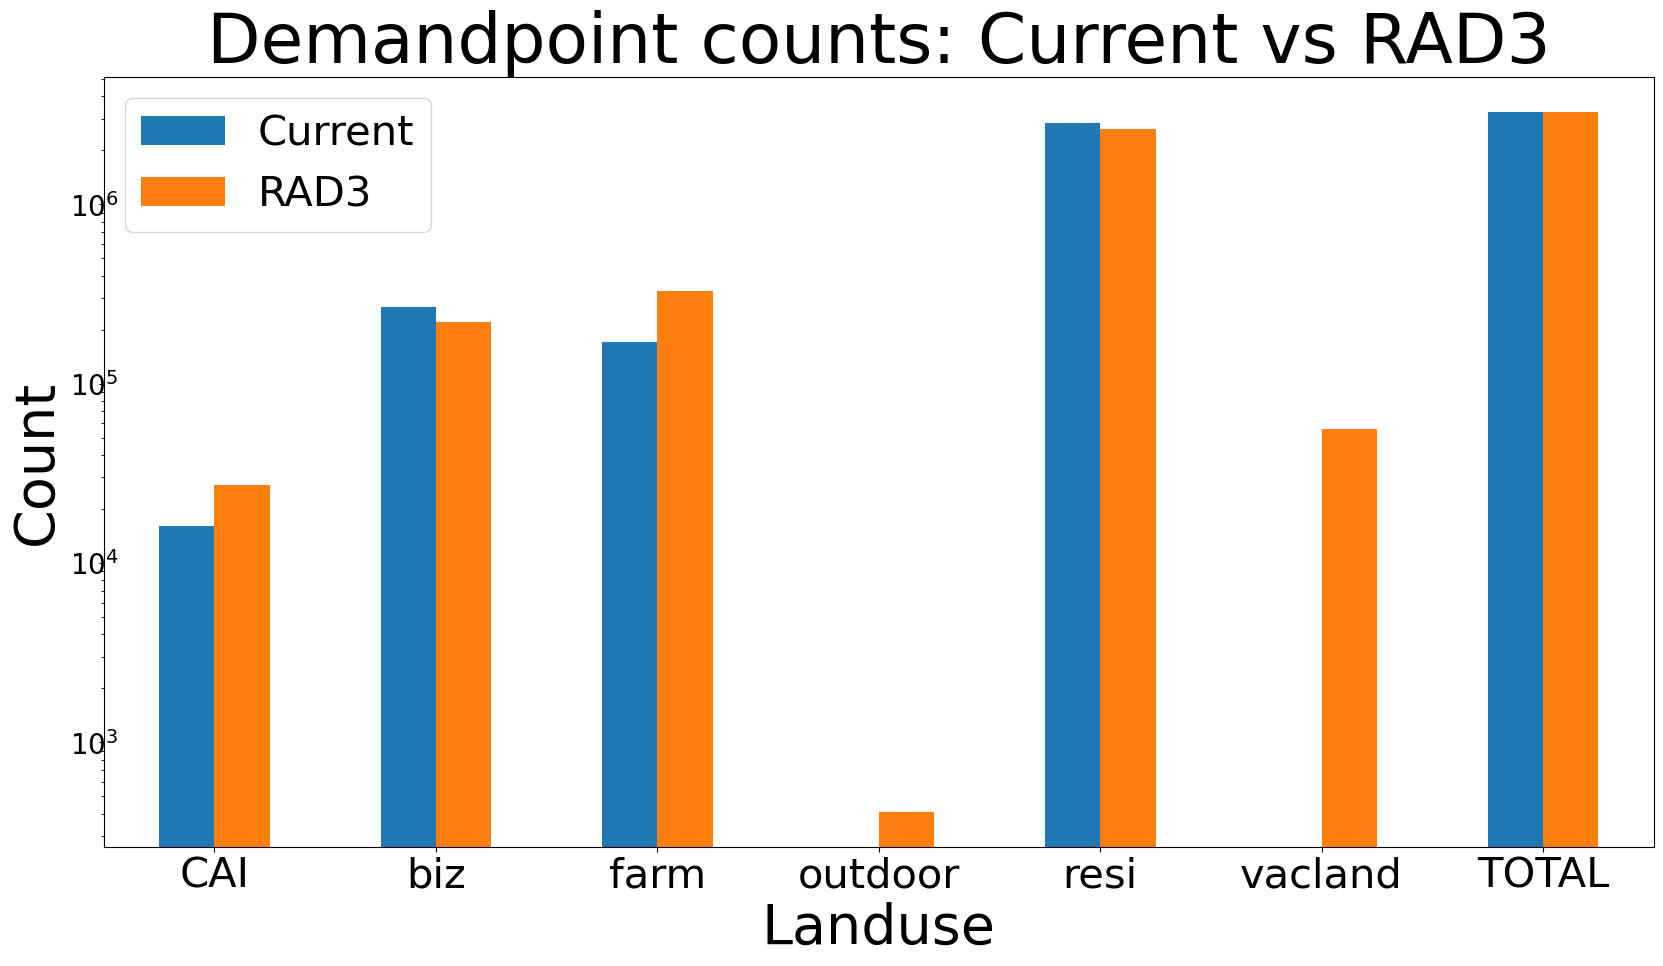

In [578]:
plotdata = pd.DataFrame({
    "Current":    [16142, 267849, 171820, 0, 2833648, 0, 3289459],
    "RAD3":   [27207, 221208, 330604, 410, 2627847, 56065, 3263341],
    }, 
    index=['CAI', 'biz',
           'farm', 'outdoor', 
           'resi', 'vacland', 'TOTAL']
)

ax = plotdata.plot(kind="bar")
import matplotlib
from matplotlib import pyplot as plt
# matplotlib.style.use('default') 
plt.rcParams["figure.figsize"] = [20, 10]
plt.title("Demandpoint counts: Current vs RAD3", fontsize=50)
plt.xticks(rotation=0, horizontalalignment="center", fontsize=30)
plt.yticks(rotation=0, horizontalalignment="center", fontsize=20)
plt.xlabel("Landuse", fontsize=40)
plt.ylabel("Count", fontsize=40)
plt.yscale("log") 
ax.legend(fontsize=30)